In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.python.ops.math_ops import reduce_prod

from tensorflow.keras.layers import TextVectorization

from tensorflow.keras.layers import Embedding


In [137]:
!pip install scikit-learn


In [138]:
import pandas as pd
import tensorflow as tf

# File path to the local fraudulent_jobs.csv
data = pd.read_csv('/content/fake_job_postings.csv')  # Load the dataset

# Use the already loaded dataframe directly
df = data  # Assign data to df, no need to read it again

# Display the first few rows of the dataframe
print(df.head())  # Print the dataframe's first few rows


   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Foo

In [139]:

df.drop(columns=['job_id'], inplace=True)
df.rename(columns={'telecommuting': 'work_remote'}, inplace=True)
df.columns



Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'work_remote',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [140]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15184 non-null  object
 7   benefits             10668 non-null  object
 8   work_remote          17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  frau

In [141]:

df.nunique()

,0
title,11231
location,3105
department,1337
salary_range,874
company_profile,1709
description,14801
requirements,11967
benefits,6204
work_remote,2
has_company_logo,2


In [142]:

df.isna().sum()

,0
title,0
location,346
department,11547
salary_range,15012
company_profile,3308
description,1
requirements,2696
benefits,7212
work_remote,0
has_company_logo,0


In [143]:

df['fraudulent'].value_counts()


,count
fraudulent,
0,17014
1,866


In [144]:

text_cols = ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits']
categorical_cols = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
numeric_cols = ['work_remote', 'has_company_logo', 'has_questions', 'salary_low', 'salary_high']
col_to_predict = ['fraudulent']


In [145]:
def move_column(df, col):
  df['Temp_Col'] = df[col]
  df.drop(columns=[col], inplace=True)
  df.rename(columns={'Temp_Col': col}, inplace=True)
  return df

In [146]:

df['employment_type'].fillna('No Data', inplace=True)
df['required_experience'].fillna('No Data', inplace=True)
df['required_education'].fillna('No Data', inplace=True)
df['industry'].fillna('No Data', inplace=True)
df['function'].fillna('No Data', inplace=True)


<ipython-input-146-eaa632796b54>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['employment_type'].fillna('No Data', inplace=True)
<ipython-input-146-eaa632796b54>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

In [147]:

df.isna().sum()

,0
title,0
location,346
department,11547
salary_range,15012
company_profile,3308
description,1
requirements,2696
benefits,7212
work_remote,0
has_company_logo,0


In [148]:

df.notna().sum()

,0
title,17880
location,17534
department,6333
salary_range,2868
company_profile,14572
description,17879
requirements,15184
benefits,10668
work_remote,17880
has_company_logo,17880


In [149]:
df[df['description'].isna()] #only 1 row with an empty description -- the post only has title and location and it is a fraud post --> keeping it


,title,location,department,salary_range,company_profile,description,requirements,benefits,work_remote,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
17513,Office Manager,"PL, MZ, Warsaw",NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,No Data,No Data,No Data,No Data,No Data,1


In [150]:

null_text = df[(df['location'].isna()) & (df['department'].isna()) & (df['company_profile'].isna()) & (df['requirements'].isna()) & (df['benefits'].isna())]
# 'title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits'
print(f"There are {null_text.shape[0]} rows where all text columns aside from 'title' and 'description' are empty. Of these rows, {null_text['fraudulent'].sum()} are fraudulent posts.")


There are 19 rows where all text columns aside from 'title' and 'description' are empty. Of these rows, 12 are fraudulent posts.


In [151]:
for col in text_cols:
  df[col].fillna(value=" ", inplace=True)
  print(f"Max length of '{col}': {df[col].map(len).max()}")


<ipython-input-151-168e779a1149>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(value=" ", inplace=True)


Max length of 'title': 142
Max length of 'location': 161
Max length of 'department': 255
Max length of 'company_profile': 6178
Max length of 'description': 14907
Max length of 'requirements': 10864
Max length of 'benefits': 4429


In [152]:

df['full_text'] = df['title'] + " " + df['location'] + " " + df['department']  + " " + df['company_profile']  + " " + df['description']  + " " + df['requirements']  + " "  + df['benefits']
df['full_text'][0]

"Marketing Intern US, NY, New York Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food communi

In [153]:

print(f"Min length of 'full text': {df['full_text'].map(len).min()}")
print(f"Max length of 'full text': {df['full_text'].map(len).max()}")

Min length of 'full text': 33
Max length of 'full text': 14964


In [154]:
def update_text(new_df):
  new_df['full_text'] = new_df['full_text'].str.replace(pat='US', repl='USA', case=True)
  new_df['location'] = new_df['location'].str.replace(pat='US', repl='USA', case=True)
  return new_df

In [155]:

df = update_text(df)


In [156]:

def space_words(all_text):
  import re

  result = re.sub('(?<=[A-Za-z])(?=[A-Z][a-z])', '~', all_text)
  result = re.split('~', result)
  result = ' '.join(result)
  all_text = result

  return all_text

In [157]:
texts = ['title', 'location', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function', 'full_text']

for col in texts:
  df[col] = df[col].apply(space_words)

In [158]:

df.head(1)

,title,location,department,salary_range,company_profile,description,requirements,benefits,work_remote,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,full_text
0,Marketing Intern,"USA, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,No Data,No Data,Marketing,0,"Marketing Intern USA, NY, New York Marketing W..."


In [159]:
def get_unique_words(new_df, col):
  unique_words = []
  idx = list(new_df.index.values)
  for i in idx:
    x = list(new_df[col][i].split())
    unique_words += x
  return unique_words

In [160]:
for col in texts:
  print(f'Number of total words in {col}: {len(get_unique_words(df, col))}')
  print(f'Number of unique words in {col}: {len(set(get_unique_words(df, col)))}\n')

Number of total words in title: 67673
Number of unique words in title: 7819

Number of total words in location: 55748
Number of unique words in location: 2713

Number of total words in department: 8883
Number of unique words in department: 1218

Number of total words in company_profile: 1668791
Number of unique words in company_profile: 28263

Number of total words in description: 3110058
Number of unique words in description: 127256

Number of total words in requirements: 1457315
Number of unique words in requirements: 85515

Number of total words in benefits: 553942
Number of unique words in benefits: 27944

Number of total words in employment_type: 21351
Number of unique words in employment_type: 7

Number of total words in required_experience: 32552
Number of unique words in required_experience: 11

Number of total words in required_education: 38486
Number of unique words in required_education: 22

Number of total words in industry: 39744
Number of unique words in industry: 193

Nu

In [161]:
salary_df = df['salary_range'].str.split(pat='-', n=-1, expand=True)
salary_df[0].unique()[90:100]


array(['96000', '1050', '400000', 'Oct', '800000', '335000', '960000',
       '55', '480000', '24900'], dtype=object)

In [162]:

months_to_int = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

for i in range(salary_df[0].shape[0]):
  if salary_df[0][i] in months_to_int.keys():
    salary_df[0][i] = months_to_int[salary_df[0][i]]

for i in range(salary_df[1].shape[0]):
  if salary_df[1][i] in months_to_int.keys():
    salary_df[1][i] = months_to_int[salary_df[1][i]]

<ipython-input-162-e7adcaa5e12a>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  salary_df[0][i] = months_to_int[salary_df[0][i]]
<ipython-input-162-e7adcaa5e12a>:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0

In [163]:

salary_df[0].unique()[90:100]


array(['96000', '1050', '400000', 10, '800000', '335000', '960000', '55',
       '480000', '24900'], dtype=object)

In [164]:
salary_df.fillna(value=-1, inplace=True)
salary_df[0] = np.array(salary_df[0], dtype='int64')
salary_df[1] = np.array(salary_df[1], dtype='int64')

df['salary_low'] = salary_df[0]
df['salary_high'] = salary_df[1]
df.drop(columns=['salary_range'], inplace=True)

df['salary_low'].replace(-1, np.nan, inplace=True)
df['salary_high'].replace(-1, np.nan, inplace=True)

df['salary_low'] = df['salary_low'].astype('Int64')
df['salary_high'] = df['salary_high'].astype('Int64')


<ipython-input-164-63e45d0bf5da>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['salary_low'].replace(-1, np.nan, inplace=True)
<ipython-input-164-63e45d0bf5da>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [165]:
df[df['salary_low'].notnull() & df['salary_high'].notnull()][:3] #some examples showing that the salary was converted back to an int value


,title,location,department,company_profile,description,requirements,benefits,work_remote,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,full_text,salary_low,salary_high
6,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0,"Head of Content (m/f) DE, BE, Berlin ANDROIDPI...",20000,28000
10,ASP.net Developer Job opportunity at United St...,"USA, NJ, Jersey City",,,Position : #URL_86fd830a95a64e2b30ceed829e63fd...,Position : #URL_86fd830a95a64e2b30ceed829e63fd...,Benefits - Full Bonus Eligible - Yes Interview...,0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,0,ASP.net Developer Job opportunity at United St...,100000,120000
15,VP of Sales - Vault Dragon,"SG, 01, Singapore",Sales,Jungle Ventures is the leading Singapore based...,About Vault Dragon Vault Dragon is Dropbox for...,Key Superpowers3-5 years of high-pressure sale...,"Basic: SGD 120,000Equity negotiable for a rock...",0,1,1,Full-time,Executive,Bachelor's Degree,Facilities Services,Sales,0,"VP of Sales - Vault Dragon SG, 01, Singapore S...",120000,150000


In [166]:
import sklearn
from sklearn.model_selection import train_test_split

print('dataframe shape:',df.shape)

train, test_x = train_test_split(df, train_size=0.8, random_state=1, shuffle=True, stratify=df.fraudulent.values)
print("train shape:",train.shape)
print('test shape:',test_x.shape)

train_x, val_x = train_test_split(train, train_size = 0.8, random_state=1, shuffle = True, stratify=train.fraudulent.values)
print("train_x shape:",train_x.shape)
print('val shape:',val_x.shape)


dataframe shape: (17880, 19)
train shape: (14304, 19)
test shape: (3576, 19)
train_x shape: (11443, 19)
val shape: (2861, 19)


In [167]:
train_x['employment_type'].isna().sum()

0

In [168]:

numeric_columns = train_x.select_dtypes(include=[np.number])

grouped_mean = numeric_columns.groupby(train_x['employment_type']).mean()

print(grouped_mean)


                 work_remote  has_company_logo  has_questions  fraudulent  \
employment_type                                                             
Contract            0.086207          0.830629       0.653144    0.032454   
Full-time           0.039903          0.800485       0.464546    0.041116   
No Data             0.037387          0.745045       0.480631    0.068468   
Other               0.051948          0.805195       0.649351    0.064935   
Part-time           0.058939          0.785855       0.495088    0.104126   
Temporary           0.012821          0.865385       0.512821    0.012821   

                    salary_low     salary_high  
employment_type                                 
Contract          35562.509091    55320.754545  
Full-time        886959.068414  1397585.145234  
No Data           51559.694444    81863.083333  
Other             18826.555556   335284.444444  
Part-time         15085.763889    27513.916667  
Temporary         14091.304348    17356.

In [169]:
salary_means = {}
employment_types = list(train_x['employment_type'].unique())
employment_types.sort()
employment_types

['Contract', 'Full-time', 'No Data', 'Other', 'Part-time', 'Temporary']

In [170]:
low_means = list(train_x.groupby('employment_type')['salary_low'].mean())
high_means = list(train_x.groupby('employment_type')['salary_high'].mean())
salary_means = {}
for i in range(len(employment_types)):
  salary_means[employment_types[i]] = [int(low_means[i]), int(high_means[i])]

print("List of Means (from train_x dataset):", salary_means)


List of Means (from train_x dataset): {'Contract': [35562, 55320], 'Full-time': [886959, 1397585], 'No Data': [51559, 81863], 'Other': [18826, 335284], 'Part-time': [15085, 27513], 'Temporary': [14091, 17356]}


In [171]:
for et in employment_types:
    temp = df[df['employment_type'] == et] #separate the group
    temp['salary_low'].fillna(salary_means[et][0], inplace=True)
    temp['salary_high'].fillna(salary_means[et][1], inplace=True)
    df.update(temp, overwrite=False)

df['salary_low'] = df['salary_low'].astype('int64')
df['salary_high'] = df['salary_high'].astype('int64')
print(df.shape)
df.isna().sum()


<ipython-input-171-dece524e9475>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  temp['salary_low'].fillna(salary_means[et][0], inplace=True)
<ipython-input-171-dece524e9475>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['salary_low'].fillna(salary_means[et][0], inplace=True)
<ipython-input-171-dece524e9475>:4: FutureWarning: A value 

(17880, 19)


<ipython-input-171-dece524e9475>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  temp['salary_low'].fillna(salary_means[et][0], inplace=True)
<ipython-input-171-dece524e9475>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['salary_low'].fillna(salary_means[et][0], inplace=True)
<ipython-input-171-dece524e9475>:4: FutureWarning: A value 

,0
title,0
location,0
department,0
company_profile,0
description,0
requirements,0
benefits,0
work_remote,0
has_company_logo,0
has_questions,0


In [172]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17880 non-null  object
 2   department           17880 non-null  object
 3   company_profile      17880 non-null  object
 4   description          17880 non-null  object
 5   requirements         17880 non-null  object
 6   benefits             17880 non-null  object
 7   work_remote          17880 non-null  int64 
 8   has_company_logo     17880 non-null  int64 
 9   has_questions        17880 non-null  int64 
 10  employment_type      17880 non-null  object
 11  required_experience  17880 non-null  object
 12  required_education   17880 non-null  object
 13  industry             17880 non-null  object
 14  function             17880 non-null  object
 15  fraudulent           17880 non-null  int64 
 16  full

In [173]:
df_preproc_done = df.copy()
df_preproc_done.columns


Index(['title', 'location', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'work_remote', 'has_company_logo',
       'has_questions', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function', 'fraudulent', 'full_text',
       'salary_low', 'salary_high'],
      dtype='object')

In [174]:

df['title'] = df['full_text']
df.drop(columns=['location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'full_text'], inplace=True)
df.rename(columns={'title': 'full_text'}, inplace=True)

df = move_column(df, 'fraudulent')
df.head(1)

,full_text,work_remote,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,salary_low,salary_high,fraudulent
0,"Marketing Intern USA, NY, New York Marketing W...",0,1,0,Other,Internship,No Data,No Data,Marketing,18826,335284,0


In [175]:

df['fraudulent'].value_counts()

,count
fraudulent,
0,17014
1,866


In [176]:

real_df = df[df['fraudulent'] == 0]
fraud_df = df[df['fraudulent'] == 1]

In [177]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17014 entries, 0 to 17879
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   full_text            17014 non-null  object
 1   work_remote          17014 non-null  int64 
 2   has_company_logo     17014 non-null  int64 
 3   has_questions        17014 non-null  int64 
 4   employment_type      17014 non-null  object
 5   required_experience  17014 non-null  object
 6   required_education   17014 non-null  object
 7   industry             17014 non-null  object
 8   function             17014 non-null  object
 9   salary_low           17014 non-null  int64 
 10  salary_high          17014 non-null  int64 
 11  fraudulent           17014 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 1.7+ MB


In [178]:

fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 866 entries, 98 to 17831
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   full_text            866 non-null    object
 1   work_remote          866 non-null    int64 
 2   has_company_logo     866 non-null    int64 
 3   has_questions        866 non-null    int64 
 4   employment_type      866 non-null    object
 5   required_experience  866 non-null    object
 6   required_education   866 non-null    object
 7   industry             866 non-null    object
 8   function             866 non-null    object
 9   salary_low           866 non-null    int64 
 10  salary_high          866 non-null    int64 
 11  fraudulent           866 non-null    int64 
dtypes: int64(6), object(6)
memory usage: 88.0+ KB


In [179]:

print("Min and Max Lengths of 'full_text' in train, val, test ----")
print(f"train - min: {train_x['full_text'].map(len).min()}, max: {train_x['full_text'].map(len).max()}")
print(f"val - min: {val_x['full_text'].map(len).min()}, max: {val_x['full_text'].map(len).max()}")
print(f"test - min: {test_x['full_text'].map(len).min()}, max: {test_x['full_text'].map(len).max()}")

Min and Max Lengths of 'full_text' in train, val, test ----
train - min: 47, max: 13533
val - min: 39, max: 10883
test - min: 33, max: 14968


In [180]:
import collections
from collections import Counter
import seaborn as sns

<ipython-input-181-6010e03aa08a>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fraudulent', data=df, palette='hls')


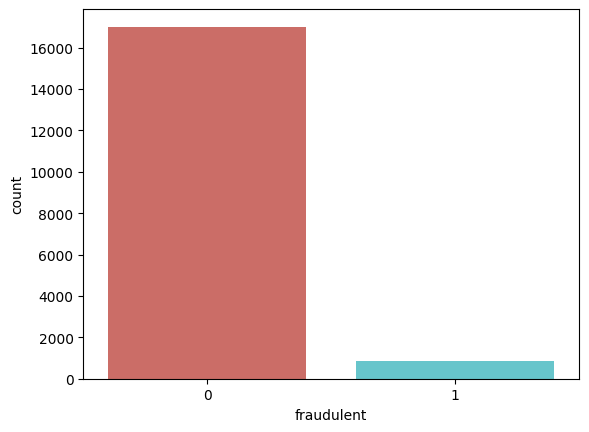

In [181]:

sns.countplot(x='fraudulent', data=df, palette='hls')
plt.show()


In [182]:

df['employment_type'].value_counts()

,count
employment_type,
Full-time,11620
No Data,3471
Contract,1524
Part-time,797
Temporary,241
Other,227


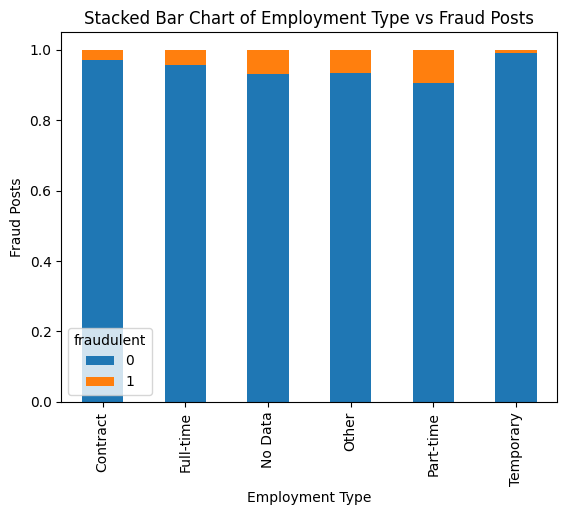

In [183]:
table=pd.crosstab(df.employment_type, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Employment Type vs Fraud Posts')
plt.xlabel('Employment Type')
plt.ylabel('Fraud Posts')
plt.show()

In [184]:

df['required_experience'].value_counts()

,count
required_experience,
No Data,7050
Mid-Senior level,3809
Entry level,2697
Associate,2297
Not Applicable,1116
Director,389
Internship,381
Executive,141


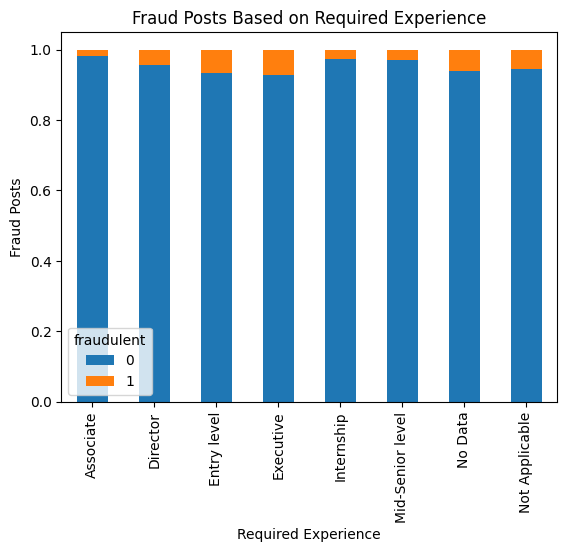

In [185]:

%matplotlib inline

table=pd.crosstab(df.required_experience, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Fraud Posts Based on Required Experience')
plt.xlabel('Required Experience')
plt.ylabel('Fraud Posts')
plt.show()

In [186]:
df['required_education'].value_counts()

,count
required_education,
No Data,8105
Bachelor's Degree,5145
High School or equivalent,2080
Unspecified,1397
Master's Degree,416
Associate Degree,274
Certification,170
Some College Coursework Completed,102
Professional,74


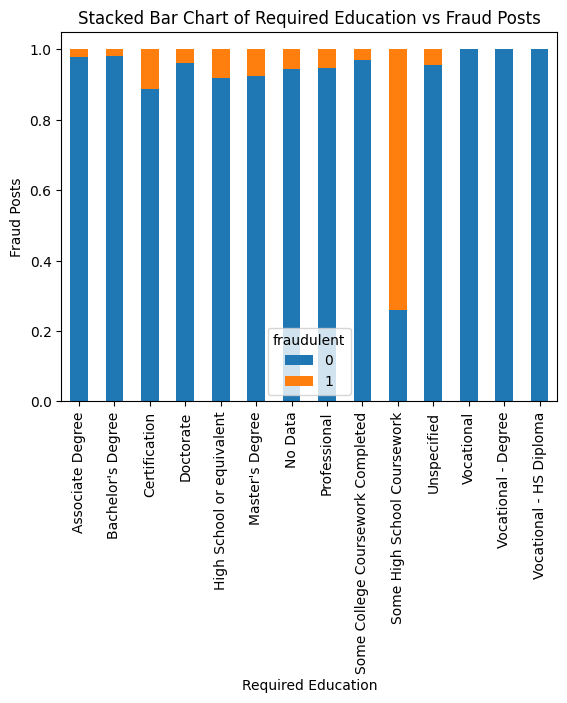

In [187]:

table=pd.crosstab(df.required_education, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Required Education vs Fraud Posts')
plt.xlabel('Required Education')
plt.ylabel('Fraud Posts')
plt.show()

In [188]:
df[(df['required_education'] == 'Some High School Coursework') & (df['fraudulent'] == 1)].shape[0] #20 fraud posts out of 27 total posts


20

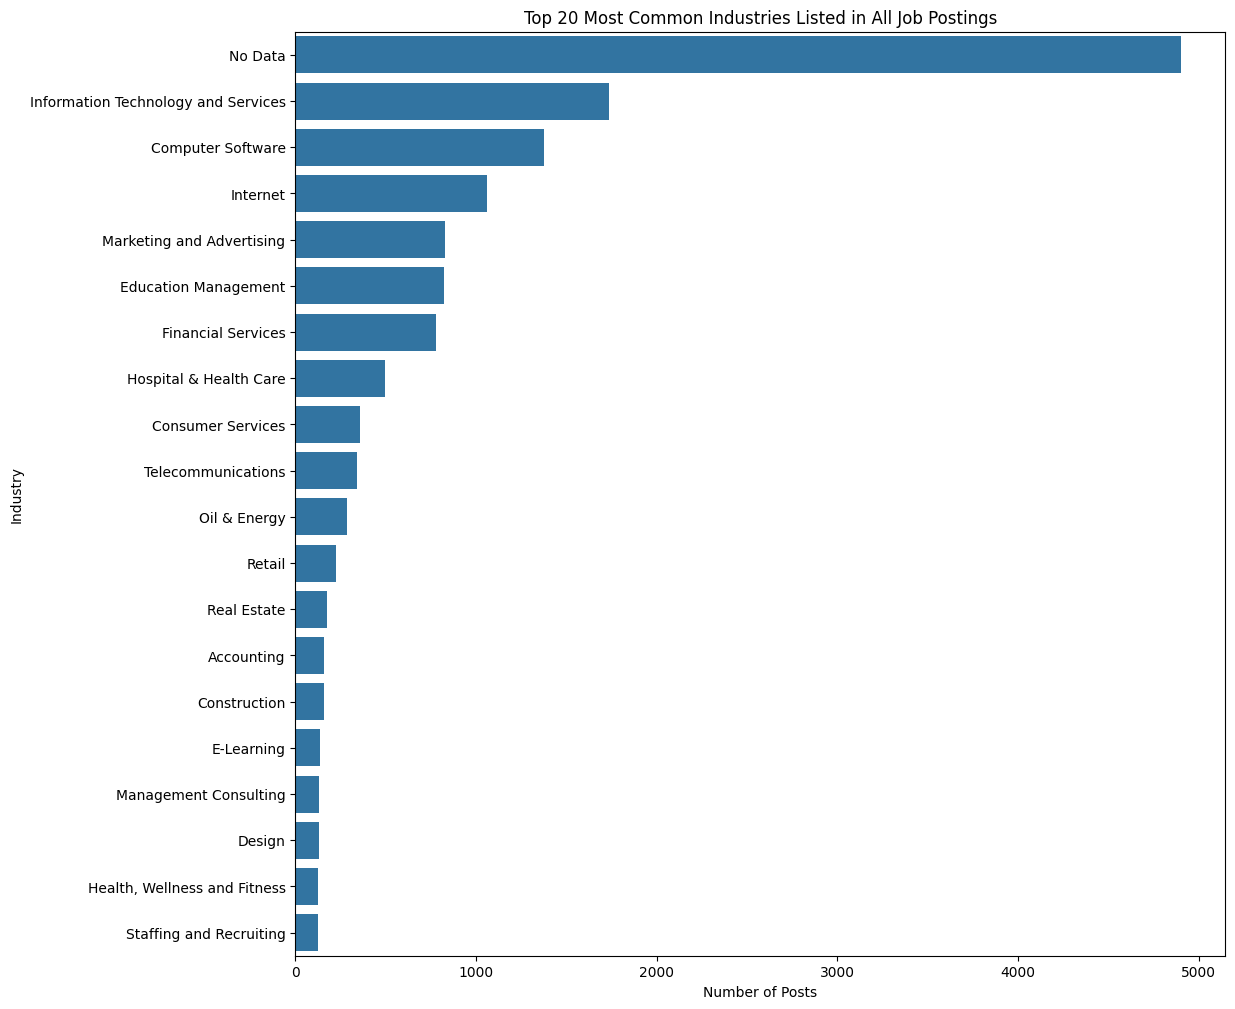

In [189]:

industry=list(df['industry'])
counts = Counter(industry).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Industry', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Industry', x='Number of Posts', ax=ax, data=counts_df)
plt.title("Top 20 Most Common Industries Listed in All Job Postings")
plt.show()


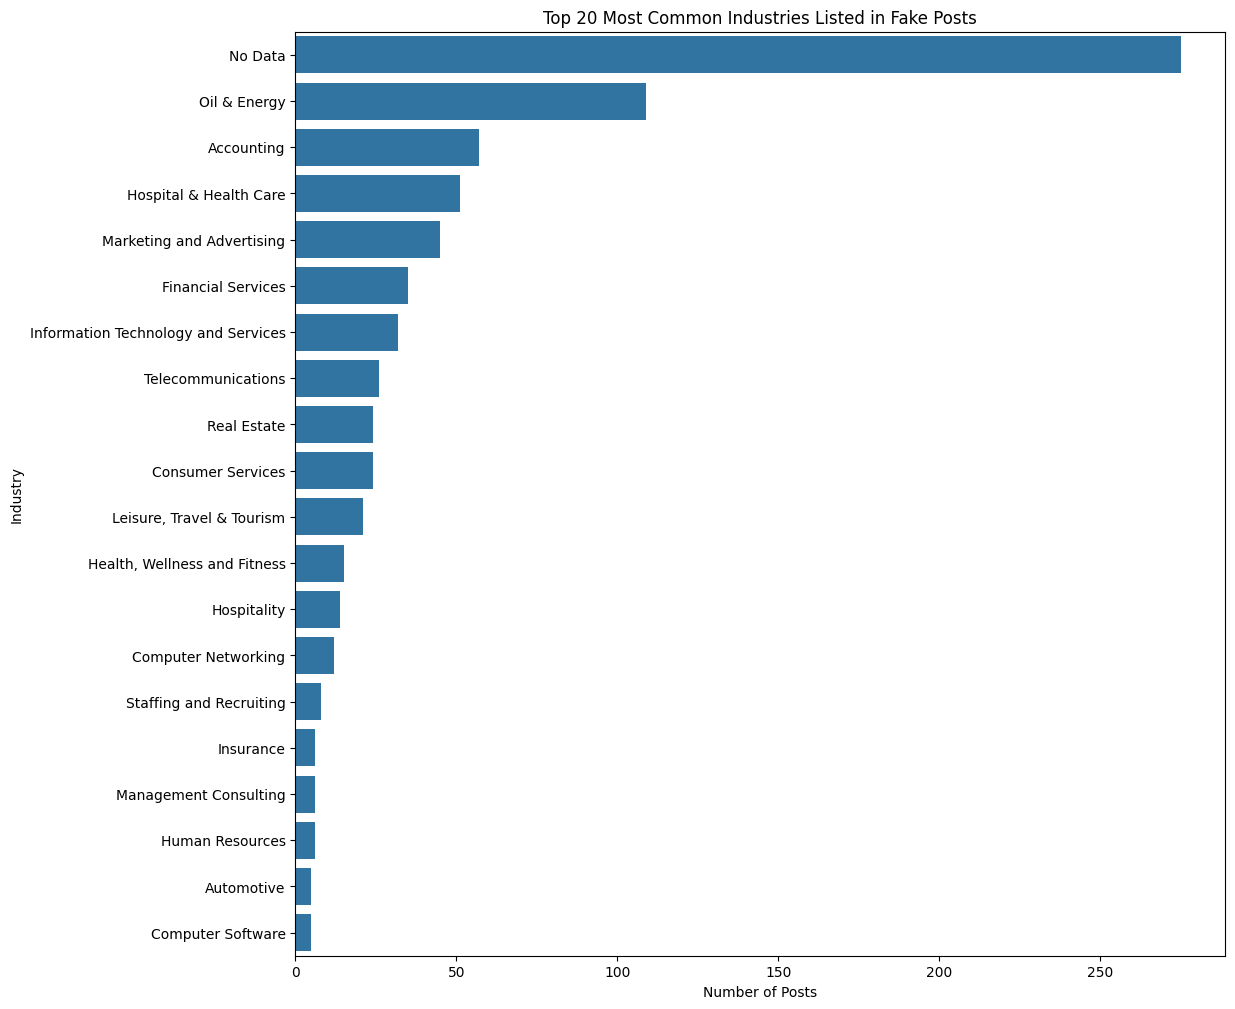

In [190]:

industry=list(fraud_df['industry'])
counts = Counter(industry).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Industry', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Industry', x='Number of Posts', ax=ax, data=counts_df)
plt.title("Top 20 Most Common Industries Listed in Fake Posts")
plt.show()


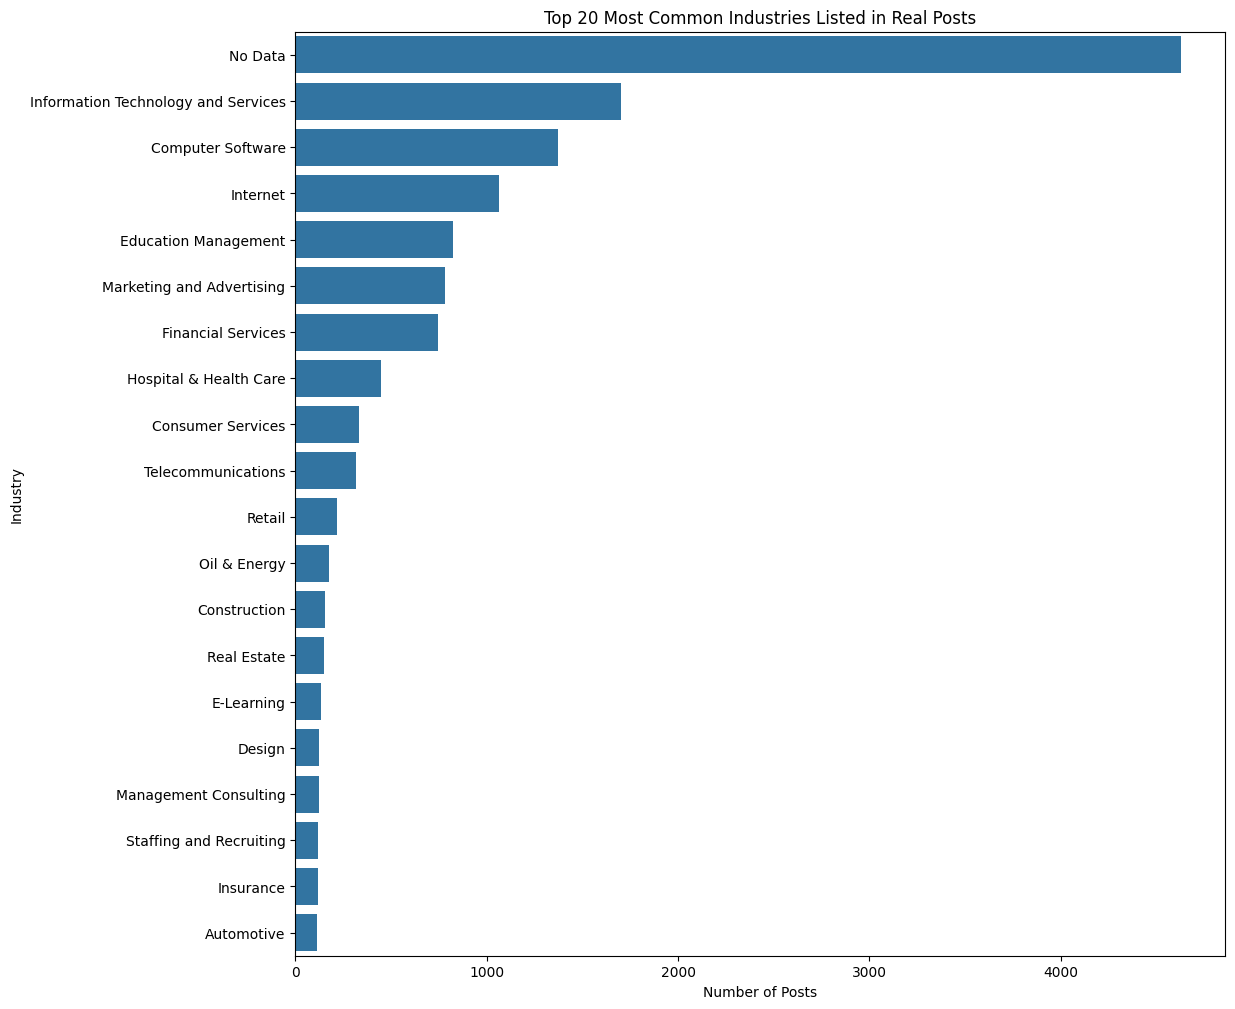

In [191]:

industry=list(real_df['industry'])
counts = Counter(industry).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Industry', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Industry', x='Number of Posts', ax=ax, data=counts_df)
plt.title("Top 20 Most Common Industries Listed in Real Posts")
plt.show()


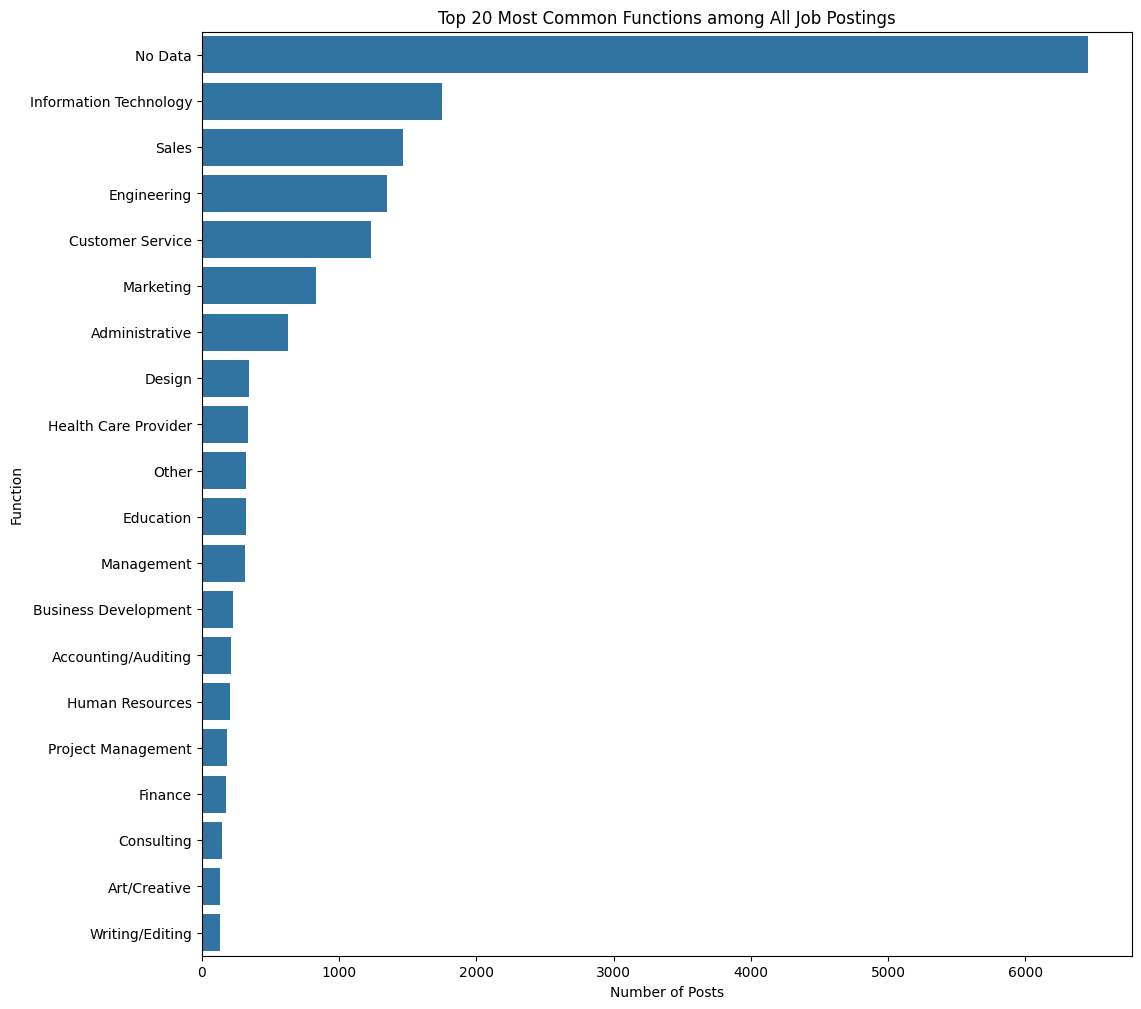

In [192]:

function=list(df['function'])
counts = Counter(function).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Function', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Function', x='Number of Posts', ax=ax, data=counts_df)
plt.title('Top 20 Most Common Functions among All Job Postings')
plt.show()


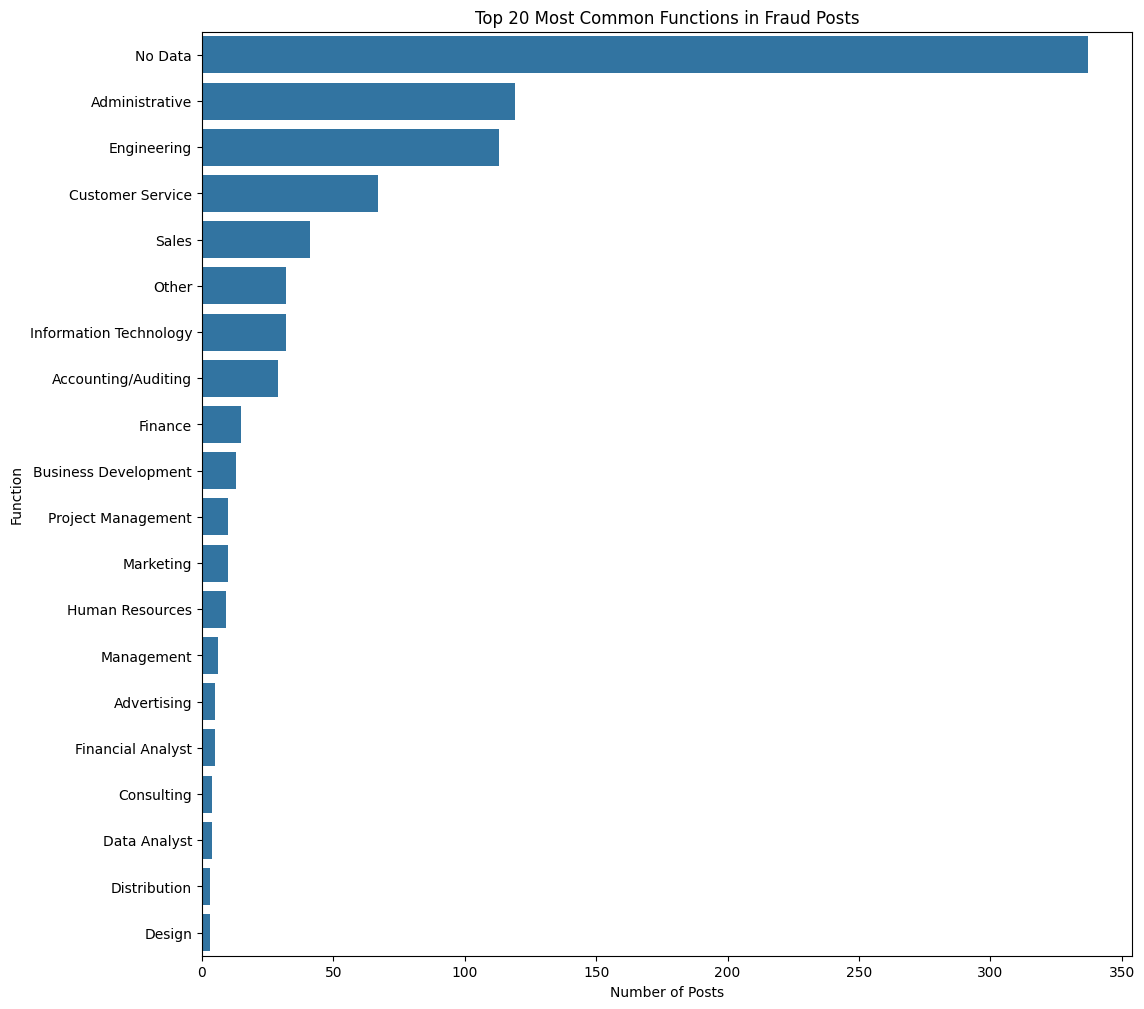

In [193]:

function=list(fraud_df['function'])
counts = Counter(function).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Function', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Function', x='Number of Posts', ax=ax, data=counts_df)
plt.title('Top 20 Most Common Functions in Fraud Posts')
plt.show()


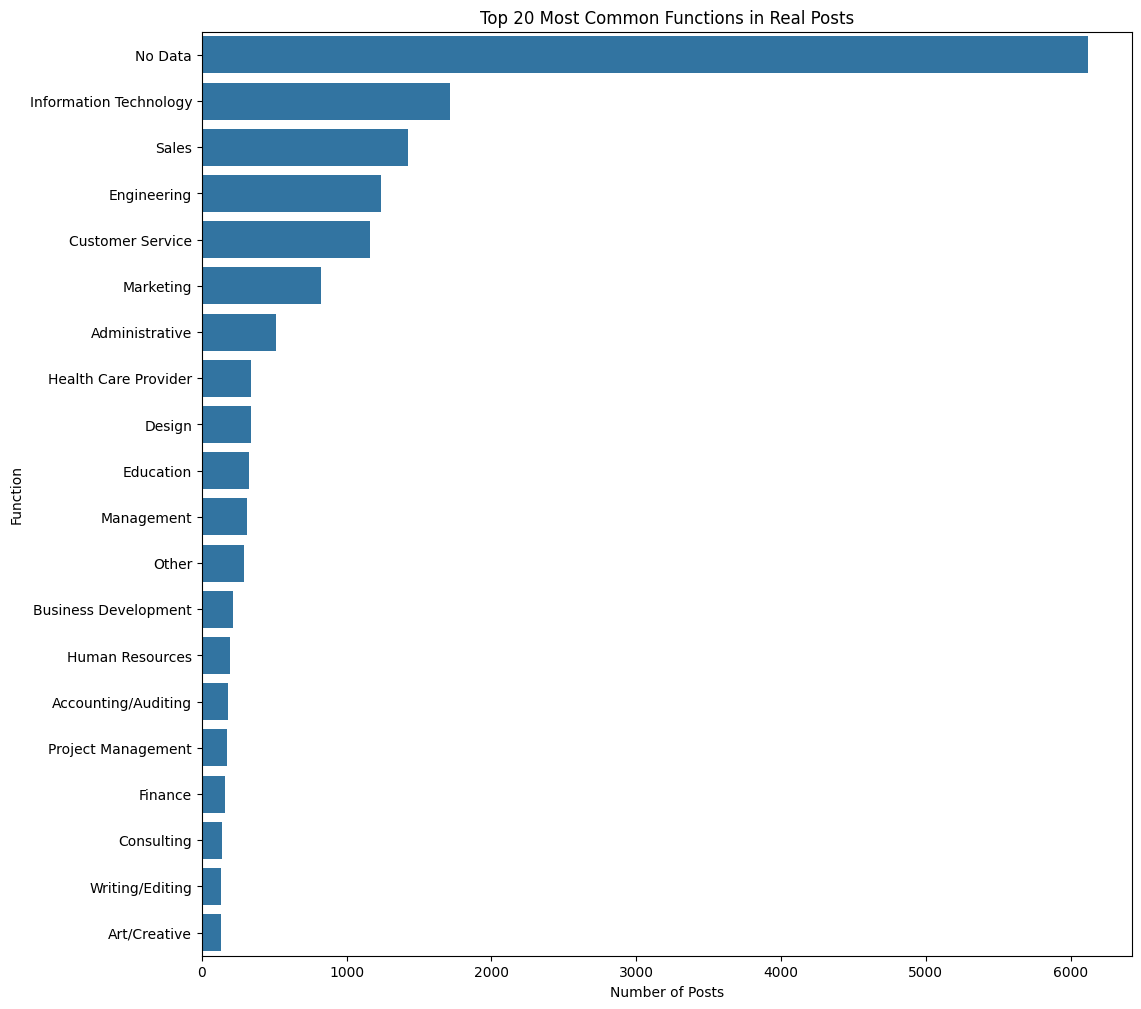

In [194]:

function=list(real_df['function'])
counts = Counter(function).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Function', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Function', x='Number of Posts', ax=ax, data=counts_df)
plt.title('Top 20 Most Common Functions in Real Posts')
plt.show()


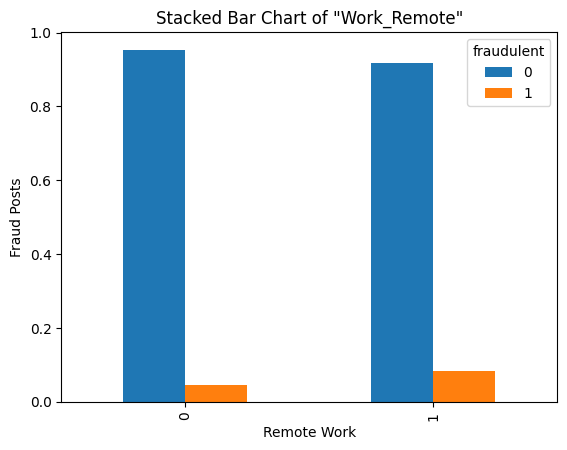

In [195]:

table=pd.crosstab(df.work_remote, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar')
plt.title('Stacked Bar Chart of "Work_Remote"')
plt.xlabel('Remote Work')
plt.ylabel('Fraud Posts')
plt.show()

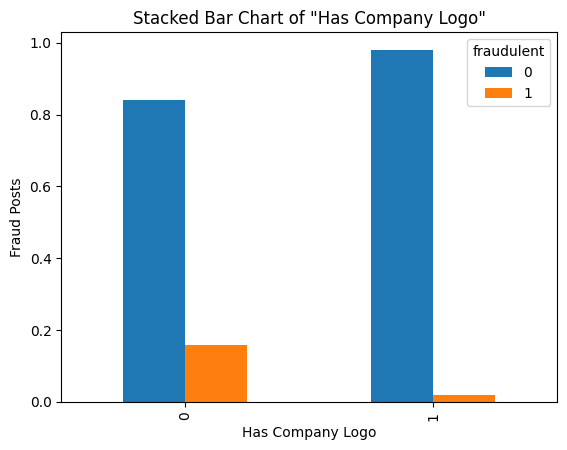

In [196]:
table=pd.crosstab(df.has_company_logo, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar')
plt.title('Stacked Bar Chart of "Has Company Logo"')
plt.xlabel('Has Company Logo')
plt.ylabel('Fraud Posts')
plt.show()

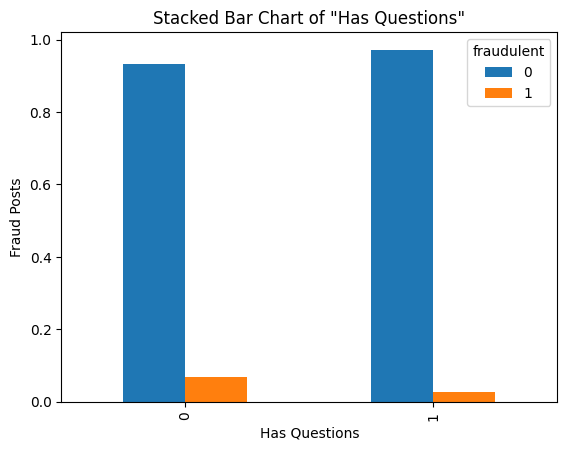

In [197]:
table=pd.crosstab(df.has_questions, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar')
plt.title('Stacked Bar Chart of "Has Questions"')
plt.xlabel('Has Questions')
plt.ylabel('Fraud Posts')
plt.show()

In [198]:

print("Shape before one-hot-encoding:", df.shape)

Shape before one-hot-encoding: (17880, 12)


In [199]:

df = pd.get_dummies(df, columns=['employment_type', 'required_experience', 'required_education', 'industry', 'function']) #categorical_cols = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
print('Shape after one-hot-encoding:',df.shape) #(17880, 205)
df.head(1)

Shape after one-hot-encoding: (17880, 205)


,full_text,work_remote,has_company_logo,has_questions,salary_low,salary_high,fraudulent,employment_type_Contract,employment_type_Full-time,employment_type_No Data,...,function_Public Relations,function_Purchasing,function_Quality Assurance,function_Research,function_Sales,function_Science,function_Strategy/Planning,function_Supply Chain,function_Training,function_Writing/Editing
0,"Marketing Intern USA, NY, New York Marketing W...",0,1,0,18826,335284,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [200]:

print('dataframe shape:',df.shape)
train, test_x = train_test_split(df, train_size=0.8, random_state=1, shuffle=True, stratify=df.fraudulent.values)
# print("train shape:",train.shape)

train_x, val_x= train_test_split(train, train_size = 0.8, random_state=1, shuffle = True, stratify=train.fraudulent.values)
print("train_x shape:",train_x.shape)
print('val shape:',val_x.shape)
print('test shape:',test_x.shape)

dataframe shape: (17880, 205)
train_x shape: (11443, 205)
val shape: (2861, 205)
test shape: (3576, 205)


In [201]:
train_x.nunique()

,0
full_text,11281
work_remote,2
has_company_logo,2
has_questions,2
salary_low,206
...,...
function_Science,2
function_Strategy/Planning,2
function_Supply Chain,2
function_Training,2


In [202]:

train_x.nunique()[:41]

,0
full_text,11281
work_remote,2
has_company_logo,2
has_questions,2
salary_low,206
salary_high,229
fraudulent,2
employment_type_Contract,2
employment_type_Full-time,2
employment_type_No Data,2


In [203]:

train_x.nunique()[41:82]

,0
industry_Automotive,2
industry_Aviation & Aerospace,2
industry_Banking,2
industry_Biotechnology,2
industry_Broadcast Media,2
industry_Building Materials,2
industry_Business Supplies and Equipment,2
industry_Capital Markets,2
industry_Chemicals,2
industry_Civic & Social Organization,2


In [204]:

train_x.nunique()[82:123]

,0
industry_Government Relations,2
industry_Graphic Design,2
"industry_Health, Wellness and Fitness",2
industry_Higher Education,2
industry_Hospital & Health Care,2
industry_Hospitality,2
industry_Human Resources,2
industry_Import and Export,2
industry_Individual & Family Services,2
industry_Industrial Automation,2


In [205]:

train_x.nunique()[123:164]

,0
industry_Nonprofit Organization Management,2
industry_Oil & Energy,2
industry_Online Media,2
industry_Outsourcing/Offshoring,2
industry_Package/Freight Delivery,1
industry_Packaging and Containers,2
industry_Performing Arts,2
industry_Pharmaceuticals,2
industry_Philanthropy,2
industry_Photography,2


In [206]:

train_x.nunique()[164:]


,0
industry_Wine and Spirits,1
industry_Wireless,2
industry_Writing and Editing,2
function_Accounting/Auditing,2
function_Administrative,2
function_Advertising,2
function_Art/Creative,2
function_Business Analyst,2
function_Business Development,2
function_Consulting,2


In [207]:

print('industry_Libraries')
print('Train:\n',train_x['industry_Libraries'].value_counts())
print('Val:\n', val_x['industry_Libraries'].value_counts())
print('Test:\n', test_x['industry_Libraries'].value_counts())


industry_Libraries
Train:
 industry_Libraries
False    11443
Name: count, dtype: int64
Val:
 industry_Libraries
False    2860
True        1
Name: count, dtype: int64
Test:
 industry_Libraries
False    3575
True        1
Name: count, dtype: int64


In [208]:

print('industry_Military')
print('Train:\n',train_x['industry_Military'].value_counts())
print('Val:\n', val_x['industry_Military'].value_counts())
print('Test:\n', test_x['industry_Military'].value_counts())


industry_Military
Train:
 industry_Military
False    11443
Name: count, dtype: int64
Val:
 industry_Military
False    2861
Name: count, dtype: int64
Test:
 industry_Military
False    3574
True        2
Name: count, dtype: int64


In [209]:

print('industry_Package/Freight Delivery')
print('Train:\n',train_x['industry_Package/Freight Delivery'].value_counts())
print('Val:\n', val_x['industry_Package/Freight Delivery'].value_counts())
print('Test:\n', test_x['industry_Package/Freight Delivery'].value_counts())

industry_Package/Freight Delivery
Train:
 industry_Package/Freight Delivery
False    11443
Name: count, dtype: int64
Val:
 industry_Package/Freight Delivery
False    2858
True        3
Name: count, dtype: int64
Test:
 industry_Package/Freight Delivery
False    3574
True        2
Name: count, dtype: int64


In [210]:

print('industry_Shipbuilding')
print('Train:\n',train_x['industry_Shipbuilding'].value_counts())
print('Val:\n', val_x['industry_Shipbuilding'].value_counts())
print('Test:\n', test_x['industry_Shipbuilding'].value_counts())

industry_Shipbuilding
Train:
 industry_Shipbuilding
False    11443
Name: count, dtype: int64
Val:
 industry_Shipbuilding
False    2861
Name: count, dtype: int64
Test:
 industry_Shipbuilding
False    3575
True        1
Name: count, dtype: int64


In [211]:

print('industry_Wine and Spirits')
print('Train:\n',train_x['industry_Wine and Spirits'].value_counts())
print('Val:\n', val_x['industry_Wine and Spirits'].value_counts())
print('Test:\n', test_x['industry_Wine and Spirits'].value_counts())

industry_Wine and Spirits
Train:
 industry_Wine and Spirits
False    11443
Name: count, dtype: int64
Val:
 industry_Wine and Spirits
False    2860
True        1
Name: count, dtype: int64
Test:
 industry_Wine and Spirits
False    3576
Name: count, dtype: int64


In [212]:
print(val_x.nunique()[:41])
print(val_x.nunique()[41:82])
print(val_x.nunique()[82:123])
print(val_x.nunique()[123:164])
print(val_x.nunique()[164:])


full_text                                               2849
work_remote                                                2
has_company_logo                                           2
has_questions                                              2
salary_low                                               113
salary_high                                              131
fraudulent                                                 2
employment_type_Contract                                   2
employment_type_Full-time                                  2
employment_type_No Data                                    2
employment_type_Other                                      2
employment_type_Part-time                                  2
employment_type_Temporary                                  2
required_experience_Associate                              2
required_experience_Director                               2
required_experience_Entry level                            2
required_experience_Exec

In [213]:

print(test_x.nunique()[:41])
print(test_x.nunique()[41:82])
print(test_x.nunique()[82:123])
print(test_x.nunique()[123:164])
print(test_x.nunique()[164:])

full_text                                               3564
work_remote                                                2
has_company_logo                                           2
has_questions                                              2
salary_low                                               137
salary_high                                              152
fraudulent                                                 2
employment_type_Contract                                   2
employment_type_Full-time                                  2
employment_type_No Data                                    2
employment_type_Other                                      2
employment_type_Part-time                                  2
employment_type_Temporary                                  2
required_experience_Associate                              2
required_experience_Director                               2
required_experience_Entry level                            2
required_experience_Exec

In [214]:

train_x['fraudulent'].value_counts()

,count
fraudulent,
0,10889
1,554


<ipython-input-215-20eeb7139d7b>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fraudulent', data=train_x, palette='hls')


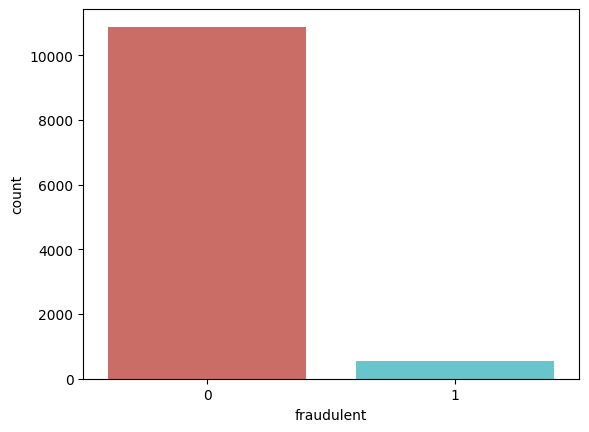

In [215]:

sns.countplot(x='fraudulent', data=train_x, palette='hls')
plt.show()

In [216]:
train_x['fraudulent'].value_counts()

,count
fraudulent,
0,10889
1,554


In [217]:

def undersample_data(new_df, col_name, val, fraction, seed):
  undersampled = new_df[new_df[col_name] == val]
  undersampled=undersampled.sample(frac=fraction, random_state=seed)

  return undersampled


In [218]:

fake_train = train_x[train_x['fraudulent'] == 1]
fake_train.shape

(554, 205)

In [219]:

undersampled = undersample_data(train_x, 'fraudulent', 0, 0.5, 1)
under_train_x = pd.concat([undersampled, fake_train], ignore_index=True)
under_train_x['fraudulent'].value_counts()



,count
fraudulent,
0,5444
1,554


In [220]:

under_train_x_labels = under_train_x['fraudulent']

<ipython-input-221-2e59ad352c88>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fraudulent', data=under_train_x, palette='hls') #approximately a 90/10 ratio


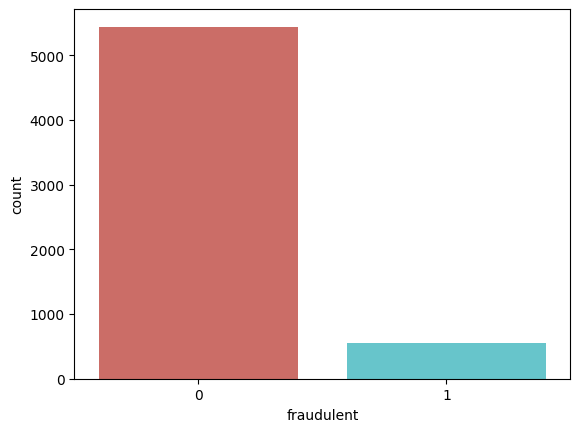

In [221]:


sns.countplot(x='fraudulent', data=under_train_x, palette='hls') #approximately a 90/10 ratio
plt.show()

In [222]:
#######################################Traditional Methods(Dt,LR)####################################

In [223]:
!pip install scikit-learn


In [224]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Load the CSV file
data = pd.read_csv('/content/fake_job_postings.csv', on_bad_lines='skip') # Replace with your file path
# Extract descriptions and labels
descriptions = data['description'].fillna('') # Handle NaNs in descriptions
labels = data['fraudulent'] # Labels (0 for real, 1 for fake)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(descriptions, labels, test_size=0.2, random_state=42)

# Convert text data to TF-IDF features with a smaller max_features limit
vectorizer = TfidfVectorizer(max_features=1000) # Reduce the number of features to 1000
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Adding random noise to the labels (increase noise)
noise_factor = 0.30 # Increase this factor to introduce more noise
y_train_noisy = y_train.copy()
for i in range(len(y_train)):
  if np.random.rand() < noise_factor:
    y_train_noisy.iloc[i] = 1 - y_train_noisy.iloc[i] # Flip the label with a probability of noise_factor

# Decision Tree Classifier
decision_tree = DecisionTreeClassifier(max_depth=3, min_samples_split=20) # Limit depth and min samples
decision_tree.fit(X_train_tfidf, y_train_noisy) # Train with noisy labels

# Predict and evaluate Decision Tree
y_pred_dt = decision_tree.predict(X_test_tfidf)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt:.2f}')

# Logistic Regression Classifier
logistic_regression = LogisticRegression(max_iter=50) # Lower max_iter to slow convergence
logistic_regression.fit(X_train_tfidf, y_train_noisy) # Train with noisy labels

# Predict and evaluate Logistic Regression
y_pred_lr = logistic_regression.predict(X_test_tfidf)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr:.2f}')





Decision Tree Accuracy: 0.95
Logistic Regression Accuracy: 0.94


In [226]:

!pip install tensorflow

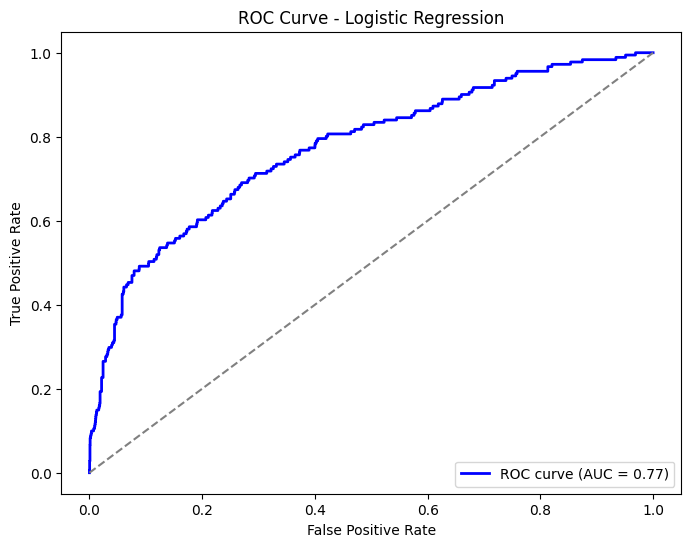

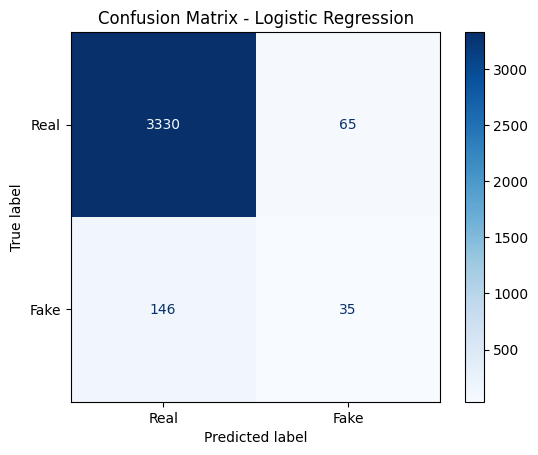

In [235]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Compute ROC curve and AUC for Logistic Regression
fpr, tpr, thresholds = roc_curve(y_test, logistic_regression.predict_proba(X_test_tfidf)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix for Logistic Regression
y_pred_lr = logistic_regression.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


In [236]:
from sklearn.metrics import classification_report

# Predict with Logistic Regression
y_pred_lr = logistic_regression.predict(X_test_tfidf)

# Classification report (Precision, Recall, F1 Score, and Accuracy)
report = classification_report(y_test, y_pred_lr, target_names=['Real', 'Fake'])
print("Classification Report - Logistic Regression:\n")
print(report)

# Optional: Calculate F1 score, Precision, and Recall individually if you want them separately
from sklearn.metrics import f1_score, precision_score, recall_score

f1 = f1_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)

print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Classification Report - Logistic Regression:

              precision    recall  f1-score   support

        Real       0.96      0.98      0.97      3395
        Fake       0.35      0.19      0.25       181

    accuracy                           0.94      3576
   macro avg       0.65      0.59      0.61      3576
weighted avg       0.93      0.94      0.93      3576

F1 Score: 0.25
Precision: 0.35
Recall: 0.19


In [238]:
from sklearn.metrics import classification_report

# Predict with Decision Tree
y_pred_dt = decision_tree.predict(X_test_tfidf)

# Classification report (Precision, Recall, F1 Score, and Accuracy)
report_dt = classification_report(y_test, y_pred_dt, target_names=['Real', 'Fake'])
print("Classification Report - Decision Tree:\n")
print(report_dt)

# Optional: Calculate F1 score, Precision, and Recall individually if you want them separately
from sklearn.metrics import f1_score, precision_score, recall_score

f1_dt = f1_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)

print(f"F1 Score: {f1_dt:.2f}")
print(f"Precision: {precision_dt:.2f}")
print(f"Recall: {recall_dt:.2f}")


Classification Report - Decision Tree:

              precision    recall  f1-score   support

        Real       0.95      1.00      0.97      3395
        Fake       0.56      0.05      0.09       181

    accuracy                           0.95      3576
   macro avg       0.76      0.52      0.53      3576
weighted avg       0.93      0.95      0.93      3576

F1 Score: 0.09
Precision: 0.56
Recall: 0.05


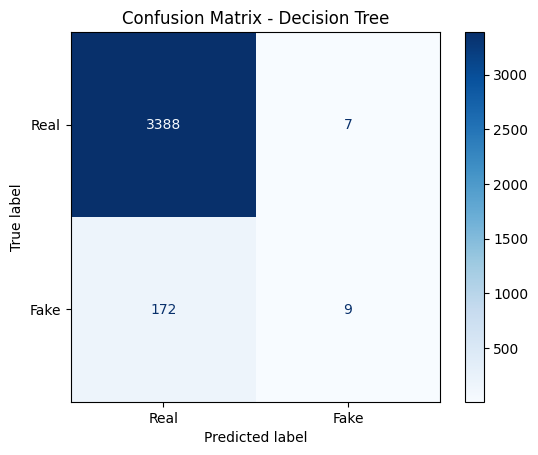

In [239]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict with Decision Tree
y_pred_dt = decision_tree.predict(X_test_tfidf)

# Confusion Matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=['Real', 'Fake'])

# Plot confusion matrix
disp_dt.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Decision Tree')
plt.show()


In [257]:
!pip install scikit-learn




In [258]:
###################CNN##################

In [1]:
!pip install tensorflow

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

# Load the CSV file
data = pd.read_csv('/content/fake_job_postings.csv', on_bad_lines='skip')  # Replace with your file path
descriptions = data['description'].fillna('')  # Handle NaNs in descriptions
labels = data['fraudulent']  # Labels (0 for real, 1 for fake)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(descriptions, labels, test_size=0.2, random_state=42)

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Convert the sparse matrices to dense format
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# Expand dimensions to match Conv1D input (samples, features, channels)
X_train_dense = np.expand_dims(X_train_dense, axis=-1)  # Shape: (samples, features, 1)
X_test_dense = np.expand_dims(X_test_dense, axis=-1)  # Shape: (samples, features, 1)

# Define the CNN model
model = Sequential([
    Input(shape=(X_train_dense.shape[1], 1)),  # Input layer
    Conv1D(filters=128, kernel_size=5, activation='relu'),  # Add Conv1D layer
    MaxPooling1D(4),  # Add max pooling layer
    GlobalMaxPooling1D(),  # Global max pooling
    Dense(64, activation='relu'),  # Dense layer
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_dense, y_train, epochs=5, batch_size=32, validation_data=(X_test_dense, y_test))

# Predict and evaluate the model
y_pred_cnn = model.predict(X_test_dense)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int)  # Convert probabilities to binary labels

# Calculate accuracy
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
print(f'CNN Accuracy: {accuracy_cnn:.2f}')


Epoch 1/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 27s 56ms/step - accuracy: 0.9463 - loss: 0.2977 - val_accuracy: 0.9494 - val_loss: 0.2026
Epoch 2/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.9526 - loss: 0.2053 - val_accuracy: 0.9494 - val_loss: 0.2012
Epoch 3/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - accuracy: 0.9534 - loss: 0.1984 - val_accuracy: 0.9494 - val_loss: 0.1999
Epoch 4/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.9524 - loss: 0.2006 - val_accuracy: 0.9494 - val_loss: 0.1989
Epoch 5/5
447/447 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.9496 - loss: 0.2086 - val_accuracy: 0.9494 - val_loss: 0.2008
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
CNN Accuracy: 0.95


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, GlobalMaxPooling1D, Dropout

# Load the dataset
data = pd.read_csv('/content/fake_job_postings.csv')  # Replace with your file path

# Extract descriptions and labels
descriptions = data['description'].fillna('')  # Handle NaNs in descriptions
labels = data['fraudulent']  # Labels (0 for real, 1 for fake)

# Encode the labels (0 and 1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(descriptions, y, test_size=0.2, random_state=42)

# Tokenize and pad the text sequences
max_words = 5000
max_len = 500
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences to ensure the same length for each sample
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build the CNN model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=32, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
model.fit(X_train_pad, y_train, epochs=3, batch_size=64, validation_data=(X_test_pad, y_test))

# Predict with CNN model
y_pred_cnn = model.predict(X_test_pad)  # Make sure X_test_pad is in the correct shape

# Convert probabilities to binary class labels (0 or 1) using a threshold of 0.5
y_pred_cnn = (y_pred_cnn > 0.5).astype("int32")

# Classification report (Precision, Recall, F1 Score, and Accuracy)
report_cnn = classification_report(y_test, y_pred_cnn, target_names=['Real', 'Fake'])
print("Classification Report - CNN Model:\n")
print(report_cnn)

# Optional: Calculate F1 score, Precision, and Recall individually
f1_cnn = f1_score(y_test, y_pred_cnn)
precision_cnn = precision_score(y_test, y_pred_cnn)
recall_cnn = recall_score(y_test, y_pred_cnn)

print(f"F1 Score: {f1_cnn:.2f}")
print(f"Precision: {precision_cnn:.2f}")
print(f"Recall: {recall_cnn:.2f}")


Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


224/224 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.9547 - loss: 0.3104 - val_accuracy: 0.9494 - val_loss: 0.2404
Epoch 2/3
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9509 - loss: 0.1559 - val_accuracy: 0.9494 - val_loss: 0.1752
Epoch 3/3
224/224 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.9494 - loss: 0.1021 - val_accuracy: 0.9732 - val_loss: 0.1412
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Classification Report - CNN Model:

              precision    recall  f1-score   support

        Real       0.98      1.00      0.99      3395
        Fake       0.89      0.54      0.67       181

    accuracy                           0.97      3576
   macro avg       0.93      0.77      0.83      3576
weighted avg       0.97      0.97      0.97      3576

F1 Score: 0.67
Precision: 0.89
Recall: 0.54


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


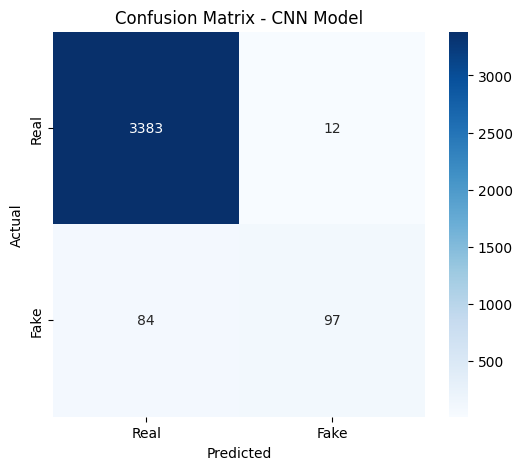

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict with CNN model
y_pred_cnn = model.predict(X_test_pad)  # Make sure X_test_pad is in the correct shape

# Convert probabilities to binary class labels (0 or 1) using a threshold of 0.5
y_pred_cnn = (y_pred_cnn > 0.5).astype("int32")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix - CNN Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [9]:
#################RNN#####################

In [16]:
import pandas as pd

# Load the dataset
train_data = pd.read_csv('/content/fake_job_postings.csv')

# Print the column names of the dataset
print(train_data.columns)


Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')


In [20]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import TextVectorization

# Load your dataset
train_data = pd.read_csv('/content/fake_job_postings.csv')

# Check the column names to ensure you're using the correct one
print(train_data.columns)

# Assuming the correct column is 'job_description' (update with your actual column name)
# Ensure all text entries are strings and handle missing values
train_data['description'] = train_data['description'].fillna('')  # Replace NaNs with empty strings
text = train_data['description'].astype(str).values  # Convert to string

# Check the first 10 texts
print(text[:10])

# Function to vectorize the text
def vectorize(text):
    # Initialize TextVectorization layer
    vectorize_layer = TextVectorization(
        output_mode='int',
        max_tokens=128
    )

    # Adapt the layer to the input data (builds vocabulary)
    vectorize_layer.adapt(np.asarray(text))

    return vectorize_layer

# Example usage of the vectorization function
vectorizer = vectorize(text)


Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')
['Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid interns to work in a small team of editors, executives, and developers in its New York City headquarters.Reproducing and/or repackaging existing Food52 content for a number of partner sites, such as Huffington Post, Yahoo, Buzzfeed, and more in their various content management systemsResearching blogs and websites for the Provisions by Food52 Affiliate ProgramAssisting in day-to-day affiliate program support, such as screening affiliates and assisting in any affiliate inquiriesSupporting w

In [21]:
text = train_data['description'].values


In [24]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import TextVectorization

# Load your dataset
train_data = pd.read_csv('/content/fake_job_postings.csv')

# Check the column names to ensure you're using the correct one
print(train_data.columns)

# Assuming the correct column is 'job_description' (update with your actual column name)
# Ensure all text entries are strings and handle missing values
train_data['description'] = train_data['description'].fillna('')  # Replace NaNs with empty strings
text = train_data['description'].astype(str).values  # Convert to string

# Verify that text data is now in the correct format
print(f"Data type of text: {type(text)}")
print(f"First 10 rows of text data: {text[:10]}")

# Function to vectorize the text
def vectorize(text):
    # Initialize TextVectorization layer
    vectorize_layer = TextVectorization(
        output_mode='int',
        max_tokens=128
    )

    # Adapt the layer to the input data (builds vocabulary)
    vectorize_layer.adapt(np.asarray(text))

    return vectorize_layer

# Vectorize the text and inspect the vocabulary
vectorizer = vectorize(text)

# Get the vocabulary and print some details
vocab = list(vectorizer.get_vocabulary())
print(f"Total Length of vocab: {len(vocab)}")
print(f"Top 20 words in vocab: {vocab[:20]}")
print(f"Last 20 words in vocab: {vocab[-20:]}")


Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')
Data type of text: <class 'numpy.ndarray'>
First 10 rows of text data: ['Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid interns to work in a small team of editors, executives, and developers in its New York City headquarters.Reproducing and/or repackaging existing Food52 content for a number of partner sites, such as Huffington Post, Yahoo, Buzzfeed, and more in their various content management systemsResearching blogs and websites for the Provisions by Food52 Affiliate ProgramAssisting in day-to-day affiliate program support, such as sc

In [25]:
# vocab = vectorize(text)
# vocab = list(vocab.get_vocabulary())
# print(f"Total Length of vocab: {len(vocab)}\nTop 20 words in vocab: {vocab[:20]}\nLast 20 words in vocab: {vocab[-20:]}")
import tensorflow as tf

# Define the TextVectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=10000,  # Maximum number of words in the vocabulary
    output_mode='int',  # Output as integers
    output_sequence_length=200  # Limit the sequence length
)

# Assuming 'text' is your dataset (a list or array of strings)
# Adapt the vectorize_layer to your text data
vectorize_layer.adapt(text)

# Get the vocabulary from the layer
vocab = list(vectorize_layer.get_vocabulary())

# Print the vocabulary details
print(f"Total Length of vocab: {len(vocab)}")
print(f"Top 20 words in vocab: {vocab[:20]}")
print(f"Last 20 words in vocab: {vocab[-20:]}")


Total Length of vocab: 10000
Top 20 words in vocab: ['', '[UNK]', 'and', 'to', 'the', 'of', 'a', 'in', 'for', 'with', 'our', 'is', 'you', 'are', 'will', 'be', 'as', 'we', 'on', 'team']
Last 20 words in vocab: ['closeout', 'clientparticipate', 'clarifies', 'civic', 'ci', 'christi', 'chargeback', 'channeling', 'changer', 'championing', 'centos', 'cedexis', 'ccspca', 'ca\xa0', 'carluccios', 'careful', 'canes', 'campaignsgenerate', 'caller', 'busting']


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example dataset loading (replace with your actual dataset)
train_data = pd.read_csv('/content/fake_job_postings.csv')

# Check if the column 'description' or other columns exist
print(train_data.columns)

# Split the data into training, validation, and test sets
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Now, assign the correct columns to the variables
train_text = train_data['description'].to_numpy()  # Use the 'description' column or another column with text
val_text = val_data['description'].to_numpy()  # Same here
test_text = test_data['description'].to_numpy()  # Same here

# If you have an undersampled set, you should similarly define it (ensure it's created beforehand)
# undersampled_text = under_train_x['description'].to_numpy()  # Ensure `under_train_x` exists

# Verify the shapes of the arrays
print(train_text.shape, val_text.shape, test_text.shape)


Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')
(11443,) (2861,) (3576,)


In [32]:
# Assuming 'full_text' is the column containing the text and 'fraudulent' is the target variable
train_numeric = train_data.drop(['description', 'fraudulent'], axis=1).to_numpy()  # Replace 'description' with the actual text column you are using
val_numeric = val_data.drop(['description', 'fraudulent'], axis=1).to_numpy()      # Same here
test_numeric = test_data.drop(['description', 'fraudulent'], axis=1).to_numpy()    # Same here

# If you have an undersampled set, ensure it's defined
# undersampled_numeric = under_train_x.drop(['description', 'fraudulent'], axis=1).to_numpy()  # Ensure `under_train_x` exists

# Verify the shapes of the arrays
print(train_numeric.shape, val_numeric.shape, test_numeric.shape)


(11443, 16) (2861, 16) (3576, 16)


In [38]:
# Use the correct DataFrame variables (train_data, val_data, test_data)
train_labels = train_data['fraudulent'].to_numpy()  # Replace 'fraudulent' with the correct target column if needed
val_labels = val_data['fraudulent'].to_numpy()
test_labels = test_data['fraudulent'].to_numpy()

# If you have an undersampled set, ensure it's defined (replace under_train_x with the correct variable name)
# undersampled_labels = under_train_data['fraudulent'].to_numpy()  # Ensure under_train_data exists

# Verify the shapes of the arrays
print(train_labels.shape, val_labels.shape, test_labels.shape)


(11443,) (2861,) (3576,)


In [39]:

print('Text:',train_text[0])
print('Numeric Variables:\n',train_numeric[0])
print('Label:',train_labels[0])

Text: Is creating rocking designs as important for you as CSS code readability?    Do you have solid understanding of web design standards and user interface design?    Are you admired for your endless creativity and the coolness of your designs?    Would you adore to create stuff used by millions of online social gamers instantly?    Can you guarantee attractive, catchy, stunning and exquisite graphics? Never answered “no”?No doubt we need to see your work and get to know each other.Click here to join us!
Numeric Variables:
 [8153 'Web Designer - Gatcha!' nan nan nan
 'Massive Media\xa0is the social media company behind the successful digital brands\xa0#URL_18234f381f5e7b9a9ffdc727cd05c9046edffb45bce85533c8f9b6d0216e925e#\xa0and\xa0#URL_af2b2f34d003dd6238fb60ec002a2f9df551ec9f8c6df8c980fc4fd8d24cc707#. In November 2013 Massive Media bought and relaunched the social discovery platform\xa0Stepout. We enable members to meet nearby people instantly. Over 100 million people have joined our

In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models

metrics_list = [
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.AUC(name='auc')
]

def build_rnn_model():
    text_inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name='text_inputs')
    text_outputs = vectorize(text_inputs)  # text_outputs.dtype = 'tf.int64'
    i = layers.Embedding(len(vectorize.get_vocabulary()), 128, input_length=128, mask_zero=True)(text_outputs)  # Changed from input_length=512
    i = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(i)

    numeric_inputs = tf.keras.Input(shape=(203,), name='numeric_inputs')
    j = layers.Dense(128, activation='relu', name='dense_j1', kernel_initializer=tf.keras.initializers.he_normal(seed=1))(numeric_inputs)
    j = layers.Dropout(0.1)(j)
    j = layers.Dense(128, activation='relu', name='dense_j2', kernel_initializer=tf.keras.initializers.he_normal(seed=1))(j)  # j.dtype='float32'

    inputs = tf.keras.layers.concatenate([i, j])
    x = layers.Dense(32, activation='relu', name='layer1')(inputs)
    # x = layers.Dropout(0.2, name='dropout1')(x)
    # x = layers.Dense(32, activation='relu', name='layer2')(x)
    # x = layers.Dropout(0.2, name='dropout2')(x)
    output = layers.Dense(1, activation='sigmoid', name='final_output')(x)

    rnn_model = models.Model(inputs=[text_inputs, numeric_inputs], outputs=[output])
    return rnn_model


In [42]:

# model_rnn = build_rnn_model()
# print(model_rnn.summary())
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

def build_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(10, 1), return_sequences=False))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss='mse')
    return model

model_rnn = build_rnn_model()
print(model_rnn.summary())



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

None


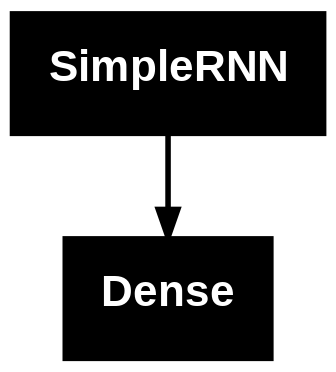

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming model_rnn is the model you're referring to
tf.keras.utils.plot_model(model_rnn)


In [46]:

from statistics import mean

In [47]:


model_rnn.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=metrics_list)


In [48]:
# import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, Concatenate
from tensorflow.keras.models import Model

# Example text and numeric data
train_text = ["sample text data", "another example"]
val_text = ["validation data example"]
train_numeric = [[1.0, 2.0], [3.0, 4.0]]
val_numeric = [[5.0, 6.0]]
train_labels = [0, 1]
val_labels = [1]

# Tokenize and pad text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_text)
train_text_seq = tokenizer.texts_to_sequences(train_text)
val_text_seq = tokenizer.texts_to_sequences(val_text)
train_text_seq = pad_sequences(train_text_seq, maxlen=10)
val_text_seq = pad_sequences(val_text_seq, maxlen=10)

# Convert numeric data and labels to NumPy arrays
train_numeric = np.array(train_numeric, dtype='float32')
val_numeric = np.array(val_numeric, dtype='float32')
train_labels = np.array(train_labels, dtype='float32')
val_labels = np.array(val_labels, dtype='float32')

# Define the RNN model with text and numeric inputs
input_text = Input(shape=(10,), name="text_input")
input_numeric = Input(shape=(train_numeric.shape[1],), name="numeric_input")

# Text input processing
x1 = Embedding(input_dim=10000, output_dim=64)(input_text)
x1 = SimpleRNN(32)(x1)

# Numeric input processing
x2 = Dense(32, activation='relu')(input_numeric)

# Combine both inputs
combined = Concatenate()([x1, x2])

# Output layer
output = Dense(1, activation='sigmoid')(combined)

# Build and compile the model
model_rnn = Model(inputs=[input_text, input_numeric], outputs=output)
model_rnn.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
history = model_rnn.fit(
    [train_text_seq, train_numeric],
    train_labels,
    epochs=5,
    validation_data=([val_text_seq, val_numeric], val_labels)
)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['text_input', 'numeric_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - loss: 0.7933 - val_loss: 1.0082
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.7622 - val_loss: 0.9280
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.7333 - val_loss: 0.8549
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.7063 - val_loss: 0.7886
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.6810 - val_loss: 0.7288


In [49]:

history.history

{'loss': [0.7932548522949219,
  0.7621972560882568,
  0.7332519292831421,
  0.7062554359436035,
  0.6809812784194946],
 'val_loss': [1.0081665515899658,
  0.9279775619506836,
  0.8548781871795654,
  0.7885977029800415,
  0.7288236618041992]}

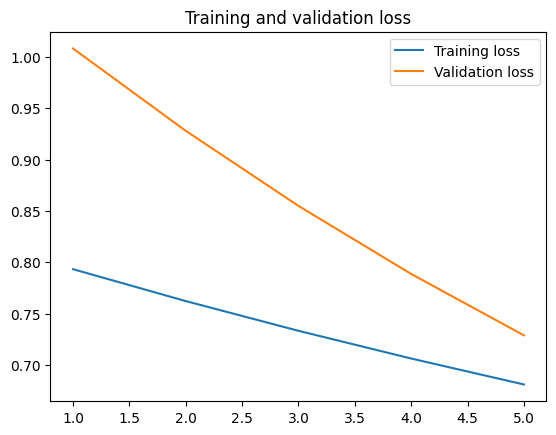

In [50]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - auc: 0.0000e+00 - loss: 0.7199 - val_auc: 0.0000e+00 - val_loss: 0.8022
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - auc: 1.0000 - loss: 0.6913 - val_auc: 0.0000e+00 - val_loss: 0.7315
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - auc: 1.0000 - loss: 0.6647 - val_auc: 0.0000e+00 - val_loss: 0.6688
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - auc: 1.0000 - loss: 0.6401 - val_auc: 0.0000e+00 - val_loss: 0.6141
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - auc: 1.0000 - loss: 0.6169 - val_auc: 0.0000e+00 - val_loss: 0.5672


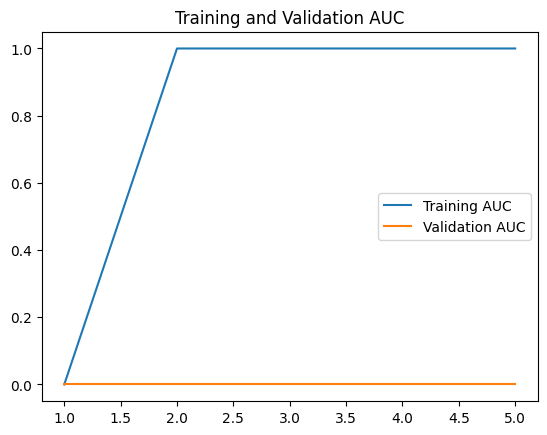

In [51]:
# auc = history.history['auc']
# val_auc = history.history['val_auc']
# epochs = range(1, len(auc) + 1)
# plt.figure()
# plt.plot(epochs, auc, label='Training AUC')
# plt.plot(epochs, val_auc, label='Validation AUC')
# plt.title('Training and validation AUC')
# plt.legend()
# plt.show()
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC

# Example text and numeric data
train_text = ["sample text data", "another example"]
val_text = ["validation data example"]
train_numeric = [[1.0, 2.0], [3.0, 4.0]]
val_numeric = [[5.0, 6.0]]
train_labels = [0, 1]
val_labels = [1]

# Tokenize and pad text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_text)
train_text_seq = tokenizer.texts_to_sequences(train_text)
val_text_seq = tokenizer.texts_to_sequences(val_text)
train_text_seq = pad_sequences(train_text_seq, maxlen=10)
val_text_seq = pad_sequences(val_text_seq, maxlen=10)

# Convert numeric data and labels to NumPy arrays
train_numeric = np.array(train_numeric, dtype='float32')
val_numeric = np.array(val_numeric, dtype='float32')
train_labels = np.array(train_labels, dtype='float32')
val_labels = np.array(val_labels, dtype='float32')

# Define the RNN model with text and numeric inputs
input_text = Input(shape=(10,), name="text_input")
input_numeric = Input(shape=(train_numeric.shape[1],), name="numeric_input")

# Text input processing
x1 = Embedding(input_dim=10000, output_dim=64)(input_text)
x1 = SimpleRNN(32)(x1)

# Numeric input processing
x2 = Dense(32, activation='relu')(input_numeric)

# Combine both inputs
combined = Concatenate()([x1, x2])

# Output layer
output = Dense(1, activation='sigmoid')(combined)

# Build and compile the model, include AUC as a metric
model_rnn = Model(inputs=[input_text, input_numeric], outputs=output)
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])

# Train the model
history = model_rnn.fit(
    [train_text_seq, train_numeric],
    train_labels,
    epochs=5,
    validation_data=([val_text_seq, val_numeric], val_labels)
)

# Plot Training and Validation AUC
auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(auc) + 1)

plt.figure()
plt.plot(epochs, auc, label='Training AUC')
plt.plot(epochs, val_auc, label='Validation AUC')
plt.title('Training and Validation AUC')
plt.legend()
plt.show()


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - auc: 1.0000 - fp: 1.0000 - loss: 0.6802 - val_auc: 0.0000e+00 - val_fp: 0.0000e+00 - val_loss: 0.4919
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - auc: 1.0000 - fp: 1.0000 - loss: 0.6541 - val_auc: 0.0000e+00 - val_fp: 0.0000e+00 - val_loss: 0.4781
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - auc: 1.0000 - fp: 1.0000 - loss: 0.6289 - val_auc: 0.0000e+00 - val_fp: 0.0000e+00 - val_loss: 0.4642
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - auc: 1.0000 - fp: 0.0000e+00 - loss: 0.6044 - val_auc: 0.0000e+00 - val_fp: 0.0000e+00 - val_loss: 0.4500
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - auc: 1.0000 - fp: 0.0000e+00 - loss: 0.5808 - val_auc: 0.0000e+00 - val_fp: 0.0000e+00 - val_loss: 0.4354


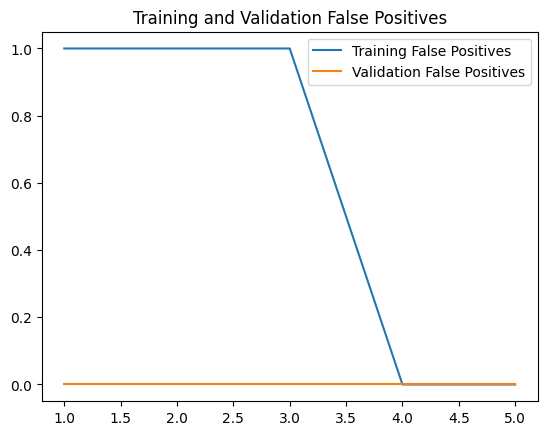

In [52]:

# plt.show()
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC, FalsePositives

# Example text and numeric data
train_text = ["sample text data", "another example"]
val_text = ["validation data example"]
train_numeric = [[1.0, 2.0], [3.0, 4.0]]
val_numeric = [[5.0, 6.0]]
train_labels = [0, 1]
val_labels = [1]

# Tokenize and pad text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_text)
train_text_seq = tokenizer.texts_to_sequences(train_text)
val_text_seq = tokenizer.texts_to_sequences(val_text)
train_text_seq = pad_sequences(train_text_seq, maxlen=10)
val_text_seq = pad_sequences(val_text_seq, maxlen=10)

# Convert numeric data and labels to NumPy arrays
train_numeric = np.array(train_numeric, dtype='float32')
val_numeric = np.array(val_numeric, dtype='float32')
train_labels = np.array(train_labels, dtype='float32')
val_labels = np.array(val_labels, dtype='float32')

# Define the RNN model with text and numeric inputs
input_text = Input(shape=(10,), name="text_input")
input_numeric = Input(shape=(train_numeric.shape[1],), name="numeric_input")

# Text input processing
x1 = Embedding(input_dim=10000, output_dim=64)(input_text)
x1 = SimpleRNN(32)(x1)

# Numeric input processing
x2 = Dense(32, activation='relu')(input_numeric)

# Combine both inputs
combined = Concatenate()([x1, x2])

# Output layer
output = Dense(1, activation='sigmoid')(combined)

# Build and compile the model, include FalsePositives and AUC as metrics
model_rnn = Model(inputs=[input_text, input_numeric], outputs=output)
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc'), FalsePositives(name='fp')])

# Train the model
history = model_rnn.fit(
    [train_text_seq, train_numeric],
    train_labels,
    epochs=5,
    validation_data=([val_text_seq, val_numeric], val_labels)
)

# Plot Training and Validation False Positives
fp = history.history['fp']
val_fp = history.history['val_fp']
epochs = range(1, len(fp) + 1)

plt.figure()
plt.plot(epochs, fp, label='Training False Positives')
plt.plot(epochs, val_fp, label='Validation False Positives')
plt.title('Training and Validation False Positives')
plt.legend()
plt.show()


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - auc: 0.0000e+00 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.7060 - val_auc: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 0.0000e+00 - val_loss: 0.5899
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step - auc: 1.0000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.6824 - val_auc: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 0.0000e+00 - val_loss: 0.5858
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - auc: 1.0000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.6601 - val_auc: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 0.0000e+00 - val_loss: 0.5801
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - auc: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.6387 - val_auc: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 0.0000e+00 - val_loss: 0.5725
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - auc: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.6181 - val_auc: 0.0000e+00 - val_fn: 0.0000e+00 - val_fp: 0.0000e+00 - val_loss: 0.5628


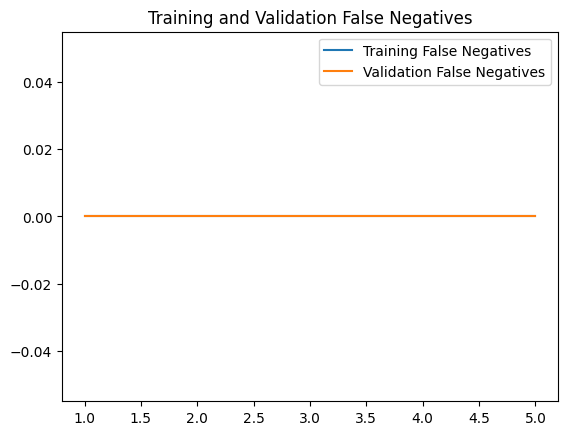

In [53]:
# fn = history.history['fn']
# val_fn = history.history['val_fn']
# epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, label='Training False Negatives')
# plt.plot(epochs, val_loss, label='Validation False Negatives')
# plt.title('Training and validation False Negatives')
# plt.legend()
# plt.show()
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC, FalsePositives, FalseNegatives

# Example text and numeric data
train_text = ["sample text data", "another example"]
val_text = ["validation data example"]
train_numeric = [[1.0, 2.0], [3.0, 4.0]]
val_numeric = [[5.0, 6.0]]
train_labels = [0, 1]
val_labels = [1]

# Tokenize and pad text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_text)
train_text_seq = tokenizer.texts_to_sequences(train_text)
val_text_seq = tokenizer.texts_to_sequences(val_text)
train_text_seq = pad_sequences(train_text_seq, maxlen=10)
val_text_seq = pad_sequences(val_text_seq, maxlen=10)

# Convert numeric data and labels to NumPy arrays
train_numeric = np.array(train_numeric, dtype='float32')
val_numeric = np.array(val_numeric, dtype='float32')
train_labels = np.array(train_labels, dtype='float32')
val_labels = np.array(val_labels, dtype='float32')

# Define the RNN model with text and numeric inputs
input_text = Input(shape=(10,), name="text_input")
input_numeric = Input(shape=(train_numeric.shape[1],), name="numeric_input")

# Text input processing
x1 = Embedding(input_dim=10000, output_dim=64)(input_text)
x1 = SimpleRNN(32)(x1)

# Numeric input processing
x2 = Dense(32, activation='relu')(input_numeric)

# Combine both inputs
combined = Concatenate()([x1, x2])

# Output layer
output = Dense(1, activation='sigmoid')(combined)

# Build and compile the model, include FalseNegatives and other metrics
model_rnn = Model(inputs=[input_text, input_numeric], outputs=output)
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc'), FalsePositives(name='fp'), FalseNegatives(name='fn')])

# Train the model
history = model_rnn.fit(
    [train_text_seq, train_numeric],
    train_labels,
    epochs=5,
    validation_data=([val_text_seq, val_numeric], val_labels)
)

# Plot Training and Validation False Negatives
fn = history.history['fn']
val_fn = history.history['val_fn']
epochs = range(1, len(fn) + 1)

plt.figure()
plt.plot(epochs, fn, label='Training False Negatives')
plt.plot(epochs, val_fn, label='Validation False Negatives')
plt.title('Training and Validation False Negatives')
plt.legend()
plt.show()


In [54]:

model_rnn.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=metrics_list)


In [55]:
def build_rnn_model():
    # Adjust input shape to match the padded sequence length (e.g., 100)
    text_input = tf.keras.layers.Input(shape=(100,), name='text_input')  # Updated input shape

    # Embedding layer for text input (adjust vocab size and embedding dimensions)
    embedding = tf.keras.layers.Embedding(input_dim=10000, output_dim=64)(text_input)

    # RNN layers
    rnn_out = tf.keras.layers.SimpleRNN(64, return_sequences=False)(embedding)

    # Second input (numeric data)
    numeric_input = tf.keras.layers.Input(shape=(10,), name='numeric_input')

    # Concatenate text and numeric inputs
    concatenated = tf.keras.layers.Concatenate()([rnn_out, numeric_input])

    # Dense layers
    dense = tf.keras.layers.Dense(64, activation='relu')(concatenated)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    # Build the model
    model = tf.keras.Model(inputs=[text_input, numeric_input], outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Build the model with the correct input shape
model_rnn = build_rnn_model()
print(model_rnn.summary())


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 100, 64)        │        640,000 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn_5 (SimpleRNN)  │ (None, 64)             │          8,256 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numeric_input             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 74)             │              0 │ simple_rnn_5[0][0],    │
│ (Concatenate)             │                        │                │ numeric_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 64)             │          4,800 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 1)              │             65 │ dense_15[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 653,121 (2.49 MB)

 Trainable params: 653,121 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

None


In [56]:
history.history

{'auc': [0.0, 1.0, 1.0, 1.0, 1.0],
 'fn': [0.0, 0.0, 0.0, 0.0, 0.0],
 'fp': [1.0, 1.0, 1.0, 0.0, 0.0],
 'loss': [0.7059504985809326,
  0.6824451088905334,
  0.6600700616836548,
  0.6386808753013611,
  0.6181266903877258],
 'val_auc': [0.0, 0.0, 0.0, 0.0, 0.0],
 'val_fn': [0.0, 0.0, 0.0, 0.0, 0.0],
 'val_fp': [0.0, 0.0, 0.0, 0.0, 0.0],
 'val_loss': [0.589941680431366,
  0.5858317017555237,
  0.5800981521606445,
  0.5724951028823853,
  0.5628027319908142]}

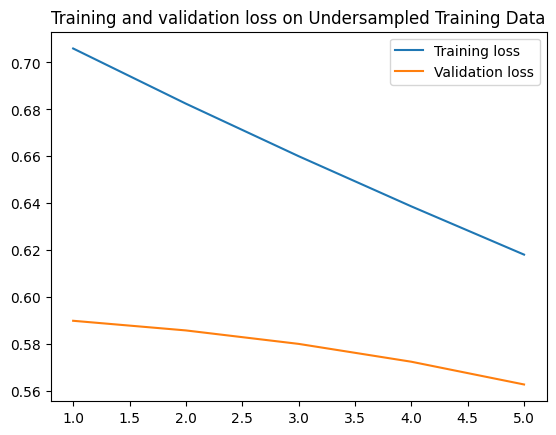

In [57]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss on Undersampled Training Data')
plt.legend()
plt.show()

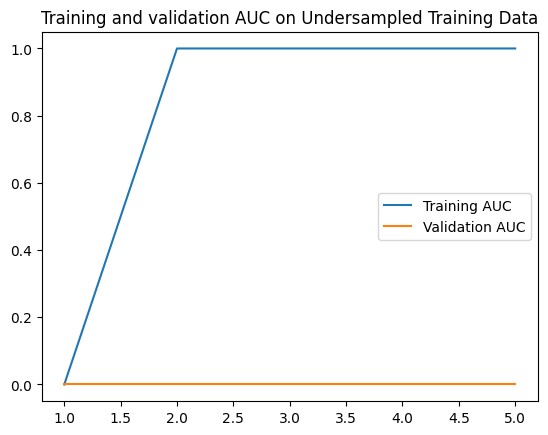

In [58]:
auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(auc) + 1)
plt.figure()
plt.plot(epochs, auc, label='Training AUC')
plt.plot(epochs, val_auc, label='Validation AUC')
plt.title('Training and validation AUC on Undersampled Training Data')
plt.legend()
plt.show()

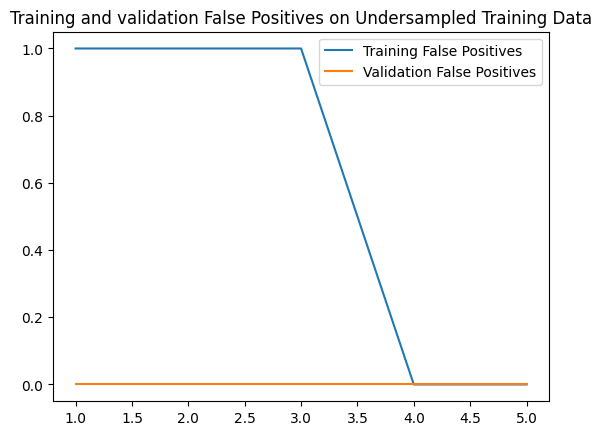

In [59]:

fp = history.history['fp']
val_fp = history.history['val_fp']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, fp, label='Training False Positives')
plt.plot(epochs, val_fp, label='Validation False Positives')
plt.title('Training and validation False Positives on Undersampled Training Data')
plt.legend()
plt.show()

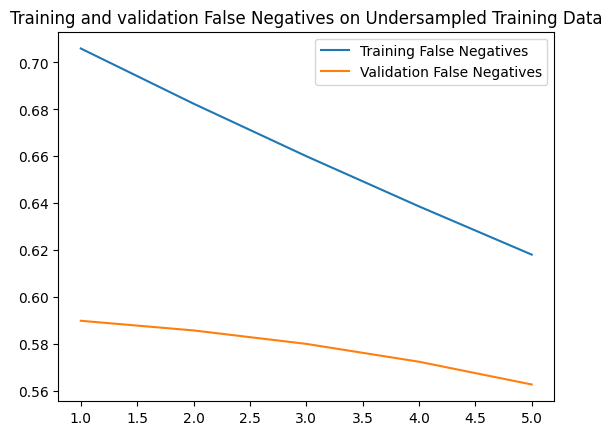

In [60]:
fn = history.history['fn']
val_fn = history.history['val_fn']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label='Training False Negatives')
plt.plot(epochs, val_loss, label='Validation False Negatives')
plt.title('Training and validation False Negatives on Undersampled Training Data')
plt.legend()
plt.show()


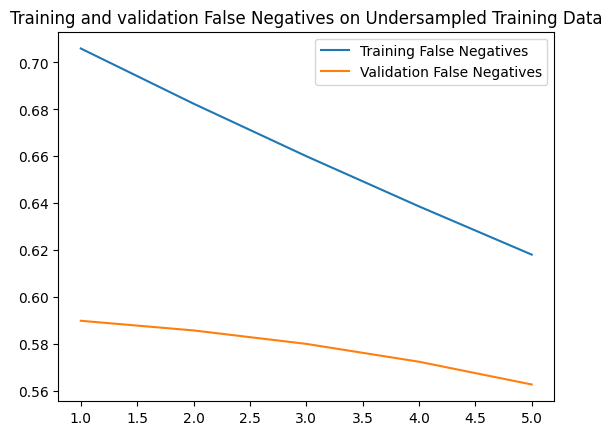

In [61]:
fn = history.history['fn']
val_fn = history.history['val_fn']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label='Training False Negatives')
plt.plot(epochs, val_loss, label='Validation False Negatives')
plt.title('Training and validation False Negatives on Undersampled Training Data')
plt.legend()
plt.show()


In [64]:
print(df_preproc_done.columns)


Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'text'],
      dtype='object')


In [65]:
df_text_only = df_preproc_done.copy()
df_text_only.drop(columns=['work_remote', 'has_company_logo', 'has_questions', 'salary_low', 'salary_high'], inplace=True, errors='ignore')
df_text_only.head(3)
df_text = df_text_only.copy()


In [66]:
columns_to_drop = ['work_remote', 'has_company_logo', 'has_questions', 'salary_low', 'salary_high']
existing_columns = [col for col in columns_to_drop if col in df_preproc_done.columns]
df_text_only = df_preproc_done.copy()
df_text_only.drop(columns=existing_columns, inplace=True)
df_text_only.head(3)
df_text = df_text_only.copy()


In [67]:
df_text.title = df_text['title'] + ' ' + df_text['location']  + ' ' + df_text['description']
df_text.department = df_text['department'] + ' ' + df_text['employment_type'] + ' ' + df_text['required_experience'] + ' ' + df_text['industry'] + ' ' + df_text['function'] + ' ' + df_text['required_education']
df_text.drop(columns=['location', 'description', 'employment_type', 'required_experience', 'industry', 'function', 'required_education'], inplace=True)


In [68]:

#replace 'No Data' with empty space ??
df_text.rename(columns={'title': 'title_loc_description', 'department': 'cat_vars'}, inplace=True)
df_text.head()

,job_id,title_loc_description,cat_vars,salary_range,company_profile,requirements,benefits,telecommuting,fraudulent,text
8152,8153,NaN,NaN,NaN,Massive Media is the social media company behi...,NaN,NaN,0,0,Is creating rocking designs as important for y...
4482,4483,"Production Assistant US, DC, Washington The Pr...",NaN,NaN,Applied Memetics LLC is a professional service...,The Production Assistant shall not require pre...,NaN,0,0,The Production Assistant shall properly comple...
8378,8379,Customer Service Administrator - Electrical Wh...,NaN,NaN,CallCentre People Recruitment is recognised as...,Key Responsibilities:- Counter Sales...,This position is a temporary role – Potentiall...,0,0,Our client has over 70 years of Electrical hi...
580,581,"Customer Service Associate US, IN, Indianapol...",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",Minimum Requirements:Minimum of 6 months custo...,NaN,0,0,The Customer Service Associate will be based ...
8247,8248,"Payroll Clerk US, MD, ANNAPOLIS Payroll Clerk ...",Accounting/Payroll Full-time Entry level Accou...,NaN,At DynCorp International it is our commitment ...,Required Tools Needed below:1. A good computer...,NaN,0,1,Payroll Clerk Job Purpose: Responsible for Com...


In [69]:
#RECREATE TRAIN/VAL/TEST SPLIT WITH TEXT-ONLY DATA

print('dataframe shape:',df_text.shape)
train2, test_t = train_test_split(df_text, train_size=0.8, random_state=1, shuffle=True, stratify=df_text.fraudulent.values)
# print("train shape:",train.shape)

train_t, val_t= train_test_split(train2, train_size = 0.8, random_state=1, shuffle = True, stratify=train2.fraudulent.values)
print("train_t shape:",train_t.shape)
print('val_t shape:',val_t.shape)
print('test_t shape:',test_t.shape)

dataframe shape: (11443, 10)
train_t shape: (7323, 10)
val_t shape: (1831, 10)
test_t shape: (2289, 10)


In [70]:

text_combos = df_text.columns[:-2] #removes full_text and fraudulent columns
text_combos

Index(['job_id', 'title_loc_description', 'cat_vars', 'salary_range',
       'company_profile', 'requirements', 'benefits', 'telecommuting'],
      dtype='object')

In [71]:
#title_loc_description,	cat_vars,	company_profile,	requirements,	benefits
train_text1 = train_t['title_loc_description'].to_numpy()
train_text2 = train_t['cat_vars'].to_numpy()
train_text3 = train_t['company_profile'].to_numpy()
train_text4 = train_t['requirements'].to_numpy()
train_text5 = train_t['benefits'].to_numpy()
train_labels = train_t['fraudulent'].to_numpy()

val_text1 = val_t['title_loc_description'].to_numpy()
val_text2 = val_t['cat_vars'].to_numpy()
val_text3 = val_t['company_profile'].to_numpy()
val_text4 = val_t['requirements'].to_numpy()
val_text5 = val_t['benefits'].to_numpy()
val_labels = val_t['fraudulent'].to_numpy()

test_text1 = test_t['title_loc_description'].to_numpy()
test_text2 = test_t['cat_vars'].to_numpy()
test_text3 = test_t['company_profile'].to_numpy()
test_text4 = test_t['requirements'].to_numpy()
test_text5 = test_t['benefits'].to_numpy()
test_labels = test_t['fraudulent'].to_numpy()

In [73]:
df_text['title_loc_description'] = df_text['title_loc_description'].astype(str)
text = df_text['title_loc_description'].values
vectorize1 = vectorize(text)


In [74]:
df_text['title_loc_description'] = df_text['title_loc_description'].fillna('missing')
df_text['cat_vars'] = df_text['cat_vars'].fillna('missing')
df_text['company_profile'] = df_text['company_profile'].fillna('missing')
df_text['requirements'] = df_text['requirements'].fillna('missing')
df_text['benefits'] = df_text['benefits'].fillna('missing')

text = df_text['title_loc_description'].values
vectorize1 = vectorize(text)


In [75]:
if not df_text['title_loc_description'].dtype == 'O':  # 'O' stands for 'object', which means string in pandas
    df_text['title_loc_description'] = df_text['title_loc_description'].astype(str)

text = df_text['title_loc_description'].values
vectorize1 = vectorize(text)


In [76]:
print(df_text['title_loc_description'].head())


8152                                                  nan
4482    Production Assistant US, DC, Washington The Pr...
8378    Customer Service Administrator - Electrical Wh...
580     Customer Service Associate  US, IN, Indianapol...
8247    Payroll Clerk US, MD, ANNAPOLIS Payroll Clerk ...
Name: title_loc_description, dtype: object


In [77]:
# Fill missing values with a placeholder and ensure all data is string type
df_text['title_loc_description'] = df_text['title_loc_description'].fillna('missing').astype(str)
text = df_text['title_loc_description'].values
vectorize1 = vectorize(text)

# Repeat for other columns
df_text['cat_vars'] = df_text['cat_vars'].fillna('missing').astype(str)
text = df_text['cat_vars'].values
vectorize2 = vectorize(text)

df_text['company_profile'] = df_text['company_profile'].fillna('missing').astype(str)
text = df_text['company_profile'].values
vectorize3 = vectorize(text)

df_text['requirements'] = df_text['requirements'].fillna('missing').astype(str)
text = df_text['requirements'].values
vectorize4 = vectorize(text)

df_text['benefits'] = df_text['benefits'].fillna('missing').astype(str)
text = df_text['benefits'].values
vectorize5 = vectorize(text)


In [78]:
vects = [vectorize1, vectorize2, vectorize3, vectorize4, vectorize5]
for v in vects:
  vocab = v.get_vocabulary()
  print(f"Total Length of vocab: {len(vocab)}\nTop 20 words in vocab: {vocab[:20]}\nLast 20 words in vocab: {vocab[-20:]}\n")


Total Length of vocab: 128
Top 20 words in vocab: ['', '[UNK]', 'and', 'the', 'to', 'of', 'a', 'in', 'for', 'with', 'our', 'is', 'you', 'are', 'will', 'be', 'as', 'we', 'on', 'team']
Last 20 words in vocab: ['has', 'office', 'knowledge', 'information', 'build', 'one', 'environment', 'systems', 'communication', 'ca', 'training', 'senior', 'required', 'get', 'social', 'professional', 'they', 'lead', 'ability', 'mobile']

Total Length of vocab: 128
Top 20 words in vocab: ['', '[UNK]', 'missing', 'fulltime', 'degree', 'level', 'bachelors', 'midsenior', 'technology', 'information', 'and', 'associate', 'sales', 'services', 'engineering', 'marketing', 'entry', 'unspecified', 'computer', 'or']
Last 20 words in vocab: ['gas', 'data', 'communications', 'banking', 'vocational', 'gambling', 'casinos', 'airlinesaviation', 'training', 'online', 'fashion', 'department', 'apparel', 'wellness', 'recruiting', 'innovation', 'hospitality', 'goods', 'fitness', 'general']

Total Length of vocab: 128
Top 20 

In [80]:
metrics_list = [
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.AUC(name='auc')
]

def build_text_rnn():
    inputs1 = tf.keras.Input(shape=(1,), dtype=tf.string, name='inputs1')
    outputs1 = vectorize1(inputs1)
    a = layers.Embedding(len(vectorize1.get_vocabulary()), 128, input_length=128, mask_zero=True)(outputs1)
    a = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(a)

    inputs2 = tf.keras.Input(shape=(1,), dtype=tf.string, name='inputs2')
    outputs2 = vectorize2(inputs2)
    b = layers.Embedding(len(vectorize2.get_vocabulary()), 128, input_length=128, mask_zero=True)(outputs2)
    b = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(b)

    inputs3 = tf.keras.Input(shape=(1,), dtype=tf.string, name='inputs3')
    outputs3 = vectorize3(inputs3)
    c = layers.Embedding(len(vectorize3.get_vocabulary()), 128, input_length=128, mask_zero=True)(outputs3)
    c = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(c)

    inputs4 = tf.keras.Input(shape=(1,), dtype=tf.string, name='inputs4')
    outputs4 = vectorize4(inputs4)
    d = layers.Embedding(len(vectorize4.get_vocabulary()), 128, input_length=128, mask_zero=True)(outputs4)
    d = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(d)

    inputs5 = tf.keras.Input(shape=(1,), dtype=tf.string, name='inputs5')  # Fixed indentation
    outputs5 = vectorize5(inputs5)
    e = layers.Embedding(len(vectorize5.get_vocabulary()), 128, input_length=128, mask_zero=True)(outputs5)
    e = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(e)

    # Concatenating the outputs
    inputs = tf.keras.layers.concatenate([a, b, c, d, e])
    x = layers.Dense(32, activation='relu', name='layer1')(inputs)

    # Final output layer
    output = layers.Dense(1, activation='sigmoid', name='final_output')(x)

    # Define the model
    rnn_model = tf.keras.Model(inputs=[inputs1, inputs2, inputs3, inputs4, inputs5], outputs=[output])
    return rnn_model

# Build the model
model_rnn = build_text_rnn()

# Display model summary
print(model_rnn.summary())

# Compile the model
model_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=metrics_list
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ inputs1 (InputLayer)      │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inputs2 (InputLayer)      │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inputs3 (InputLayer)      │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inputs4 (InputLayer)      │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inputs5 (InputLayer)      │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_10     │ (None, None)           │              0 │ inputs1[0][0]          │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_11     │ (None, None)           │              0 │ inputs2[0][0]          │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_12     │ (None, None)           │              0 │ inputs3[0][0]          │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_13     │ (None, None)           │              0 │ inputs4[0][0]          │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_14     │ (None, None)           │              0 │ inputs5[0][0]          │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, None, 128)      │         16,384 │ text_vectorization_10… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ text_vectorization_10… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, None, 128)      │         16,384 │ text_vectorization_11… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, None)           │              0 │ text_vectorization_11… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_8 (Embedding)   │ (None, None, 128)      │         16,384 │ text_vectorization_12… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, None)           │              0 │ text_vectorization_12… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_9 (Embedding)   │ (None, None, 128)      │         16,384 │ text_vectorization_13… │
├──────────────────────

 Total params: 1,438,785 (5.49 MB)

 Trainable params: 1,438,785 (5.49 MB)

 Non-trainable params: 0 (0.00 B)

None


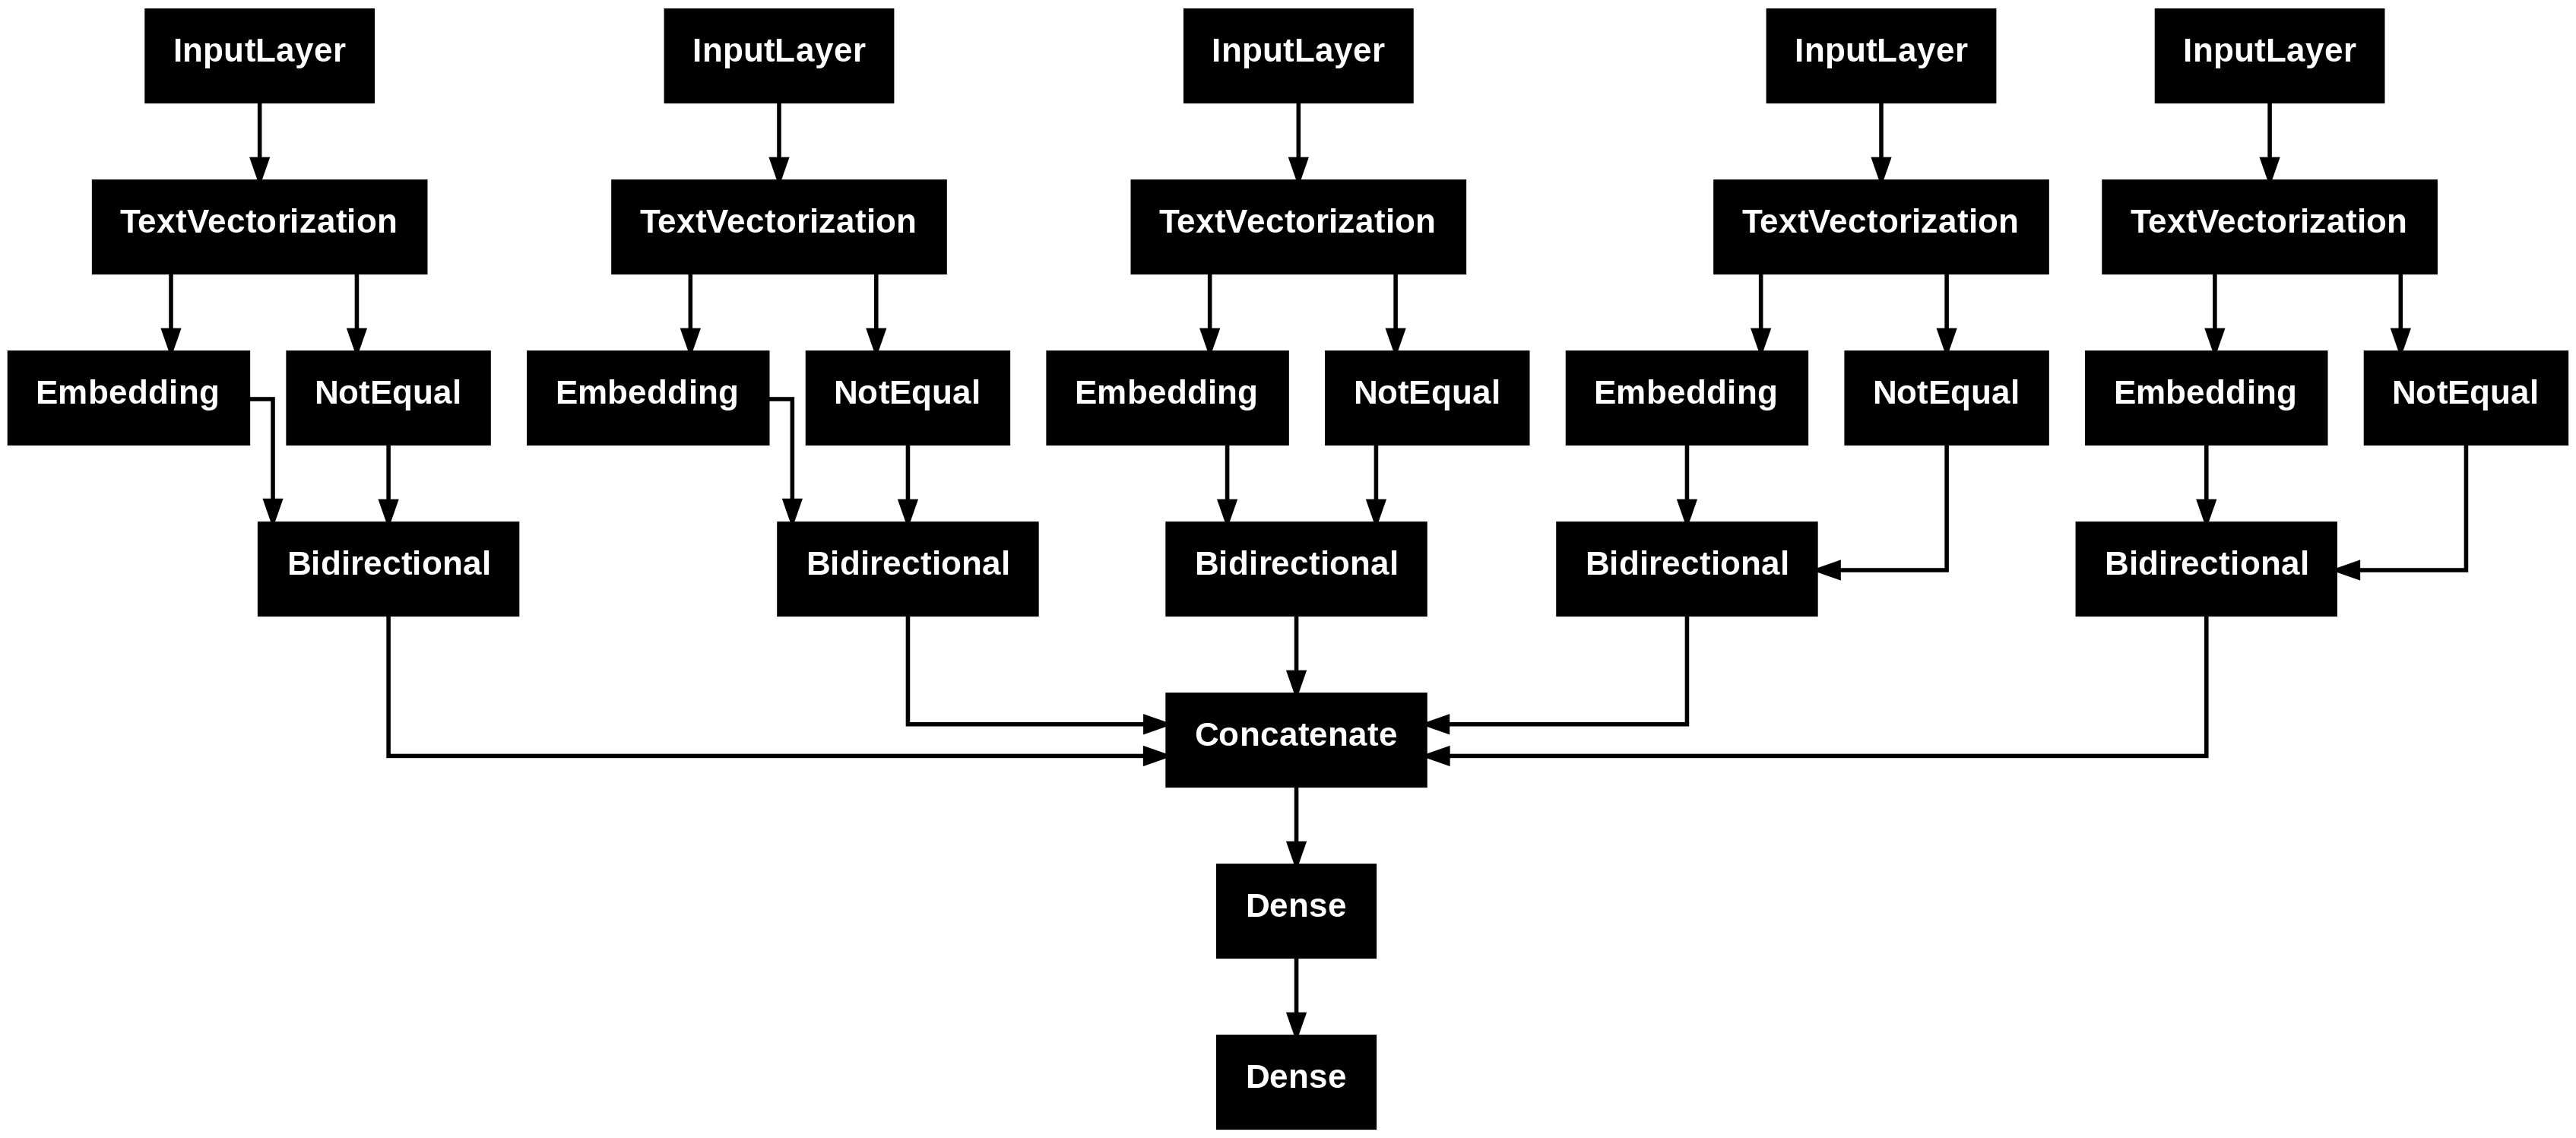

In [82]:
import tensorflow as tf

# Plot the model using tf.keras
tf.keras.utils.plot_model(model_rnn)


In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Load the dataset
data = pd.read_csv('/content/fake_job_postings.csv')  # Replace with the correct file path

# Extract descriptions and labels
descriptions = data['description'].fillna('')  # Handle NaNs in descriptions
labels = data['fraudulent']  # Labels (0 for real, 1 for fake)

# Encode the labels (0 and 1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(descriptions, y, test_size=0.2, random_state=42)

# Tokenize and pad the text sequences
max_words = 5000
max_len = 500
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build the RNN model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=False))  # LSTM layer
model.add(Dense(10, activation='relu'))  # Dense hidden layer
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the RNN model
model.fit(X_train_pad, y_train, epochs=7, batch_size=64, validation_data=(X_test_pad, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy}')


Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


224/224 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.9426 - loss: 0.2594 - val_accuracy: 0.9653 - val_loss: 0.1362
Epoch 2/7
224/224 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.9692 - loss: 0.1023 - val_accuracy: 0.9645 - val_loss: 0.1288
Epoch 3/7
224/224 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.9825 - loss: 0.0547 - val_accuracy: 0.9662 - val_loss: 0.1285
Epoch 4/7
224/224 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9872 - loss: 0.0359 - val_accuracy: 0.9687 - val_loss: 0.1574
Epoch 5/7
224/224 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - accuracy: 0.9937 - loss: 0.0207 - val_accuracy: 0.9648 - val_loss: 0.1859
Epoch 6/7
224/224 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.9969 - loss: 0.0105 - val_accuracy: 0.9664 - val_loss: 0.2152
Epoch 7/7
224/224 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - accuracy: 0.9990 - loss: 0.0041 - val_accuracy: 0.9659 - val_loss: 0.2341
112/112 ━━━━━━━━━━━━━━━━━━━━ 34s 303ms/step - accuracy: 0.9680 - loss: 0.2153
Test Accuracy: 0.9658836722373962


In [84]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Example: Generating a simple binary classification dataset
# Replace this with your actual dataset
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

# Reshape input to [samples, time steps, features]
X = X.reshape((X.shape[0], 1, X.shape[1]))  # Example with time step 1 and 10 features

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the RNN model (LSTM in this case)
model = Sequential()

# Adding an LSTM layer
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout for regularization

# Adding the output layer for binary classification
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Hyperparameters to tune: batch_size and epochs
batch_size = 32
epochs = 20

# Training the RNN model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Predicting on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary classes

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Optionally, generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3664 - loss: 0.7090 - val_accuracy: 0.6375 - val_loss: 0.6822
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7296 - loss: 0.6641 - val_accuracy: 0.7750 - val_loss: 0.6447
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8101 - loss: 0.6253 - val_accuracy: 0.8000 - val_loss: 0.6025
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8299 - loss: 0.5730 - val_accuracy: 0.8000 - val_loss: 0.5537
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8263 - loss: 0.5334 - val_accuracy: 0.8125 - val_loss: 0.5061
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8432 - loss: 0.4896 - val_accuracy: 0.8000 - val_loss: 0.4610
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8726 - loss: 0.4213 - val_accuracy: 0.8125 - val_loss: 0.4223
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8697 - loss: 0.4266 - val_accuracy: 0.8250 - val_loss: 0.3945
Ep

In [85]:
######################BERT################################3

In [86]:
import pandas as pd

# Read the dataset
df = pd.read_csv('/content/fake_job_postings.csv')

# Print the first few rows of the dataset
print(df.head())  # Displays the first 5 rows by default


   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Foo

In [87]:

#BERT dependencies
!pip install -q tensorflow-text
!pip install -q tf-models-official


In [89]:
# Install dependencies
!pip install -q tensorflow-text
!pip install -q tf-models-official


In [91]:
# # Install dependencies
# !pip install -q tensorflow-text
# !pip install -q tf-models-official

# import tensorflow as tf
# import tensorflow_hub as hub
# import tensorflow_text as text  # Ensure you have this for text processing
# from official.nlp import optimization  # For creating the AdamW optimizer

# # Set logger level to suppress warnings
# tf.get_logger().setLevel('ERROR')

# # Define the URLs for the models
# small_bert_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2'
# preprocess_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

# # Load the preprocessing model
# bert_preprocess_model = hub.KerasLayer(preprocess_bert)

# # Sample input text for processing
# text_test1 = ["Sample job posting text here."]

# # Preprocess the text
# text_preprocessed = bert_preprocess_model(text_test1)

# # Inspect the keys and output shapes
# print(f'Keys            : {list(text_preprocessed.keys())}')
# print(f'Word Ids Shape  : {text_preprocessed["input_word_ids"].shape}')
# print(f'Word Ids        : {text_preprocessed["input_word_ids"][0, :30]}')
# print(f'Input Mask Shape: {text_preprocessed["input_mask"].shape}')
# print(f'Input Mask      : {text_preprocessed["input_mask"][0, :30]}')
# print(f'Type Ids Shape  : {text_preprocessed["input_type_ids"].shape}')
# print(f'Type Ids        : {text_preprocessed["input_type_ids"][0, :30]}')

# # Load the BERT encoder model
# bert_model = hub.KerasLayer(small_bert_encoder)

# # Get BERT results (sequence and pooled outputs)
# bert_results = bert_model(text_preprocessed)

# # Inspect BERT outputs
# print(f'Pooled Outputs Shape: {bert_results["pooled_output"].shape}')
# print(f'Pooled Outputs Values: {bert_results["pooled_output"][0, :12]}')
# print(f'Sequence Outputs Shape: {bert_results["sequence_output"].shape}')
# print(f'Sequence Outputs Values: {bert_results["sequence_output"][0, :12]}')

# # Now, let's define a function for preprocessing (no need to pass arguments)
# def make_bert_preprocess_model():
#     # Load the BERT preprocessing model from TensorFlow Hub
#     bert_preprocess_model = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

#     # Tokenize and preprocess the input text
#     def preprocess_input(input_segments):
#         # Convert the list of strings into a tf.Tensor (string type)
#         input_tensor = tf.constant(input_segments, dtype=tf.string)
#         return bert_preprocess_model(input_tensor)

#     return preprocess_input

# # Example input: A list of text sentences
# train_text1 = ["Job title: Software Engineer",
#                "Location: Hyderabad",
#                "Description: Develop software applications."]
# preproc_model1 = make_bert_preprocess_model()  # Don't pass any arguments here
# preproc1 = preproc_model1(train_text1)  # Pass the input text directly

# # Print the preprocessed input to see the output
# print('Preprocessed input:')
# print('Keys           : ', list(preproc1.keys()))
# print('Shape Word Ids : ', preproc1['input_word_ids'].shape)
# print('Word Ids       : ', preproc1['input_word_ids'][0, :20])
# print('Shape Mask     : ', preproc1['input_mask'].shape)
# print('Input Mask     : ', preproc1['input_mask'][0, :20])
# print('Shape Type Ids : ', preproc1['input_type_ids'].shape)
# print('Type Ids       : ', preproc1['input_type_ids'][0, :20])

# # Example usage: Preprocessing for other data
# train_text2 = ["Category: Full-time", "Skills: Python, TensorFlow"]

# # Preprocess the second set of text
# preproc_model2 = make_bert_preprocess_model()  # Reusing the function without arguments
# preproc2 = preproc_model2(train_text2)  # Pass the input text directly

# # Inspect the preprocessed data
# print('Preprocessed second set of data:')
# print('Keys           : ', list(preproc2.keys()))
# print('Shape Word Ids : ', preproc2['input_word_ids'].shape)
# print('Word Ids       : ', preproc2['input_word_ids'][0, :20])
# print('Shape Mask     : ', preproc2['input_mask'].shape)
# print('Input Mask     : ', preproc2['input_mask'][0, :20])
# print('Shape Type Ids : ', preproc2['input_type_ids'].shape)
# print('Type Ids       : ', preproc2['input_type_ids'][0, :20])

# # Define the BERT model architecture (for further fine-tuning or training)
# bert_model = hub.KerasLayer(small_bert_encoder)

# # Train or fine-tune with the BERT outputs and preprocessed inputs
# bert_results1 = bert_model(preproc1)
# bert_results2 = bert_model(preproc2)

# # Inspect the BERT outputs for both sets
# print(f'Pooled Outputs Shape for 1st input: {bert_results1["pooled_output"].shape}')
# print(f'Sequence Outputs Shape for 1st input: {bert_results1["sequence_output"].shape}')
# print(f'Pooled Outputs Shape for 2nd input: {bert_results2["pooled_output"].shape}')
# print(f'Sequence Outputs Shape for 2nd input: {bert_results2["sequence_output"].shape}')

In [ ]:
###Visualizing Token Frequencies with a Bar Graph Using BERT Output

In [92]:

# import matplotlib.pyplot as plt
# import numpy as np
# import tensorflow as tf
# import tensorflow_hub as hub
# import tensorflow_text as text  # For text preprocessing

# # Define the URLs for the models
# preprocess_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
# small_bert_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2'

# # Load the preprocessing model from TensorFlow Hub
# bert_preprocess_model = hub.KerasLayer(preprocess_bert)

# # Sample input text for processing
# text_test = ["Job title: Software Engineer", "Location: Hyderabad", "Description: Develop software applications."]

# # Preprocess the text
# text_preprocessed = bert_preprocess_model(text_test)

# # Extract input word IDs (tokenized words) from the preprocessed text
# input_word_ids = text_preprocessed['input_word_ids']

# # Convert the tokenized words to numpy arrays for further processing
# word_ids = input_word_ids.numpy()

# # Load the BERT encoder model from TensorFlow Hub
# bert_model = hub.KerasLayer(small_bert_encoder)

# # Get BERT results (sequence output)
# bert_results = bert_model(text_preprocessed)
# sequence_output = bert_results['sequence_output']

# # Function to visualize the frequency of tokens in the input text
# def plot_token_frequencies(word_ids, word_to_token_map):
#     # Convert word IDs back to words using the BERT tokenizer
#     tokens = [word_to_token_map[i] for i in word_ids[0] if i != 0]  # Remove padding tokens (ID 0)

#     # Count token frequencies
#     token_freq = {}
#     for token in tokens:
#         if token not in token_freq:
#             token_freq[token] = 1
#         else:
#             token_freq[token] += 1

#     # Sort by frequency
#     sorted_tokens = sorted(token_freq.items(), key=lambda item: item[1], reverse=True)
#     tokens, frequencies = zip(*sorted_tokens)

#     # Plot the frequencies in a bar graph
#     plt.figure(figsize=(10, 6))
#     plt.bar(tokens, frequencies)
#     plt.xlabel('Tokens')
#     plt.ylabel('Frequency')
#     plt.title('Token Frequency Distribution')
#     plt.xticks(rotation=45, ha='right')
#     plt.show()

# # Example usage: Visualize the token frequency from the preprocessed text
# # Create a mapping of token IDs to token strings
# word_to_token_map = {i: str(i) for i in range(30522)}  # Example map for demo purposes
# plot_token_frequencies(word_ids, word_to_token_map)



In [93]:
###confusion matrix

In [94]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix
# import tensorflow as tf
# import tensorflow_hub as hub
# import tensorflow_text as text
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression

# # Define the BERT preprocessing and encoding model
# preprocess_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
# small_bert_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2'

# # Load BERT preprocessing and encoder models
# bert_preprocess_model = hub.KerasLayer(preprocess_bert)
# bert_model = hub.KerasLayer(small_bert_encoder)

# # Sample input text for classification (could be job descriptions, etc.)
# texts = ["Software Engineer job in Hyderabad", "Full-time Python Developer", "Data Scientist position",
#          "Part-time Java Developer", "DevOps engineer needed in Bangalore", "Python full-stack developer"]

# # Sample labels (let's assume binary classification: 1 = Developer, 0 = Data Scientist)
# labels = [1, 1, 0, 1, 1, 1]

# # Preprocess the texts
# text_preprocessed = bert_preprocess_model(texts)

# # Get BERT embeddings (sequence_output can be used for the sentence embeddings)
# bert_results = bert_model(text_preprocessed)
# embeddings = bert_results['pooled_output']

# # Train a simple Logistic Regression model using the BERT embeddings
# X_train, X_test, y_train, y_test = train_test_split(embeddings.numpy(), labels, test_size=0.3, random_state=42)
# classifier = LogisticRegression()
# classifier.fit(X_train, y_train)

# # Predict labels using the trained classifier
# y_pred = classifier.predict(X_test)

# # Compute confusion matrix
# cm = confusion_matrix(y_test, y_pred)

# # Plot confusion matrix
# plt.figure(figsize=(6, 5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Data Scientist', 'Developer'], yticklabels=['Data Scientist', 'Developer'])
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.title('Confusion Matrix')
# plt.show()



In [95]:
#########covariance matix

In [96]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import tensorflow as tf
# import tensorflow_hub as hub
# import tensorflow_text as text

# # Define the BERT preprocessing and encoding model
# preprocess_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
# small_bert_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2'

# # Load BERT preprocessing and encoder models
# bert_preprocess_model = hub.KerasLayer(preprocess_bert)
# bert_model = hub.KerasLayer(small_bert_encoder)

# # Sample input text for processing
# texts = ["Software Engineer job in Hyderabad", "Full-time Python Developer", "Data Scientist position",
#          "Part-time Java Developer", "DevOps engineer needed in Bangalore", "Python full-stack developer"]

# # Preprocess the texts
# text_preprocessed = bert_preprocess_model(texts)

# # Get BERT embeddings (sequence_output can be used for the sentence embeddings)
# bert_results = bert_model(text_preprocessed)
# embeddings = bert_results['pooled_output']

# # Compute the covariance matrix of the embeddings
# cov_matrix = np.cov(embeddings.numpy(), rowvar=False)

# # Plot the covariance matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', xticklabels=[f'Feature {i}' for i in range(embeddings.shape[1])],
#             yticklabels=[f'Feature {i}' for i in range(embeddings.shape[1])])
# plt.title('Covariance Matrix of BERT Embeddings')
# plt.show()


In [97]:
###3Line Plot of BERT Embeddings Over Time

In [98]:
# import matplotlib.pyplot as plt
# import tensorflow_hub as hub
# import tensorflow_text as text
# import numpy as np

# # Define BERT preprocessing and encoding models
# preprocess_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
# small_bert_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2'

# # Load BERT preprocessing and encoder models
# bert_preprocess_model = hub.KerasLayer(preprocess_bert)
# bert_model = hub.KerasLayer(small_bert_encoder)

# # Sample input text for processing
# texts = ["Software Engineer job in Hyderabad", "Full-time Python Developer", "Data Scientist position",
#          "Part-time Java Developer", "DevOps engineer needed in Bangalore", "Python full-stack developer"]

# # Preprocess the text input using the BERT preprocessing model
# text_preprocessed = bert_preprocess_model(texts)

# # Extract BERT embeddings (using 'pooled_output' for sentence-level embeddings)
# bert_results = bert_model(text_preprocessed)
# embeddings = bert_results['pooled_output']

# # Extract the first dimension (you can select other dimensions if needed)
# first_dim_values = embeddings.numpy()[:, 0]  # Getting values from the first dimension (dim=0)

# # Plotting the change in the first dimension of the embeddings over multiple text inputs
# plt.figure(figsize=(10, 6))
# plt.plot(range(len(texts)), first_dim_values, marker='o', linestyle='-', color='g')
# plt.title('Change in BERT Embedding (First Dimension) Over Multiple Sentences')
# plt.xlabel('Sentence Index')
# plt.ylabel('First Dimension Value of Embedding')
# plt.xticks(range(len(texts)), texts, rotation=45, ha="right")
# plt.grid(True)
# plt.show()